# SWSN - EaT-PIM with simplified ingredients and ingredient metadata

Bartosz Stachowiak 148259<br>
Andrzej Kajdasz 148273

## 1. Introduction
After reading [EaT-PIM: Substituting Entities in Procedural Instructions using Flow Graphs and Embeddings (Sola S. Shirai, HyeongSik Kim)](https://dspace.rpi.edu/bitstream/handle/20.500.13015/6364/ISWC_EaT_PIM.pdf?sequence=1&isAllowed=y&fbclid=IwAR3RaVCT2_kb0T5NmVNs2ulIxjWkbDBu8T9wfUrIk7pSrjLcRQEeA6BqVkg) we noticed a room for improvement in the appraoch. We hypothesize that we could improve the results by incorporating other information besides the ingredients themselves to improve the quality of the suggestions.
<br><br>
The first and most important task for us is to incorporate ingredient metadata in substitute prediction. The proposed model utilizes only the contextual information about the ingredient from recipes, which is not always accurate (completely different ingredients might be prepared in similar ways but do not taste alike). To improve the quality of the prediction, we could incorporate the metadata about individual ingredients (e.g. taste, type) and make a prediction as a combination of the two sources. The plan for us is to describe the metadata in form of a feature matrix (one-hot encoded), combine similarity metric between the missing ingredient and its alternatives, combine the metric with paper's original approach using weights, find most appropriate replacements
<br><br>
The second proposition equally important is to simplify the ingredients to get more informative predictions. The authors seem to have used very granular distinction between individual ingredients, which sometimes give very unhelpful substitution propositions (e.g. pork => boneless pork). Simplifying the distinction and grouping very similar ingredients could help with more insightful predictions. To achieve such results we will prune any modifiers from existing ingredients (e.g. boneless pork), aggregate ingredients to their simplest form.

We strongly believe that with these two changes, we will be able to improve upon the initial solution.

## 2. EDA

### 2.1 Original Dataset

Raw data are taken from [kaggle - Food.com Recipes and Interactions dataset](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions).

This dataset was created by scraping over 230k recipies from [Food.com](food.com).

In [80]:
import itertools
import collections
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [81]:
df = pd.read_csv('data/RAW_recipes.csv')
df.set_index('id', inplace=True)
df.head()

,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
id,,,,,,,,,,,
137739,arriba baked winter squash mexican style,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
31490,a bit different breakfast pizza,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
112140,all in the kitchen chili,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
59389,alouette potatoes,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
44061,amish tomato ketchup for canning,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


#### 2.1.1. Column Description

The dataset consists of recipies, each described by the following:
- **name** - name of the recipe, string, lowercase 
- **id** - id of the recipe, int
- **minutes** - time needed to prepare the recipe in minutes, int
- **contributor_id** - id of the contributor, int
- **submitted** - date of submission, string, format: YYYY-MM-DD
- **tags** - tags of the recipe, list of lowercase strings
- **nutrition** - nutrition information, list of 7 floats:
  - **calories (#)**
  - **total fat (PDV)**
  - **sugar (PDV)**
  - **sodium (PDV)**
  - **protein (PDV)**
  - **saturated fat (PDV)**
  - **carbohydrates (PDV)**
- **n_steps** - number of steps in the recipe, int
- **steps** - steps of the recipe, list of strings
- **description** - description of the recipe, string
- **ingredients** - ingredients of the recipe, list of strings
- **n_ingredients** - number of ingredients in the recipe, int

The authors of the paper have used only the **ingredients** and **steps** columns, which we will also use in our approach.

In [82]:
def parse_string_list(string_list: str) -> list[str]:
    return [token[1:-1] for token in string_list[1:-1].replace(" , ", "; ").split(", ")]

ingredients = df.ingredients.apply(parse_string_list).tolist()
steps = df.steps.apply(parse_string_list).tolist()

#### 2.1.2. Ingredients

On average, each recipe has 9 ingredients.

In [83]:
df.n_ingredients.describe()

count    231637.000000
mean          9.051153
std           3.734796
min           1.000000
25%           6.000000
50%           9.000000
75%          11.000000
max          43.000000
Name: n_ingredients, dtype: float64

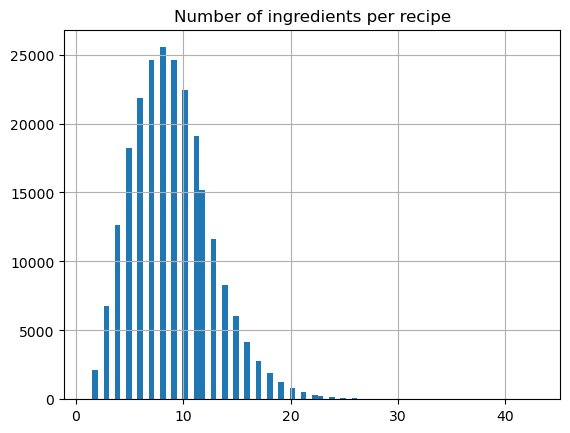

In [84]:
df.n_ingredients.hist(bins=80)
plt.title("Number of ingredients per recipe")
plt.show()

In [85]:
ingredient_counts = collections.Counter(itertools.chain.from_iterable(ingredients))

print("Total number of ingredients:", len(ingredient_counts))

Total number of ingredients: 14917


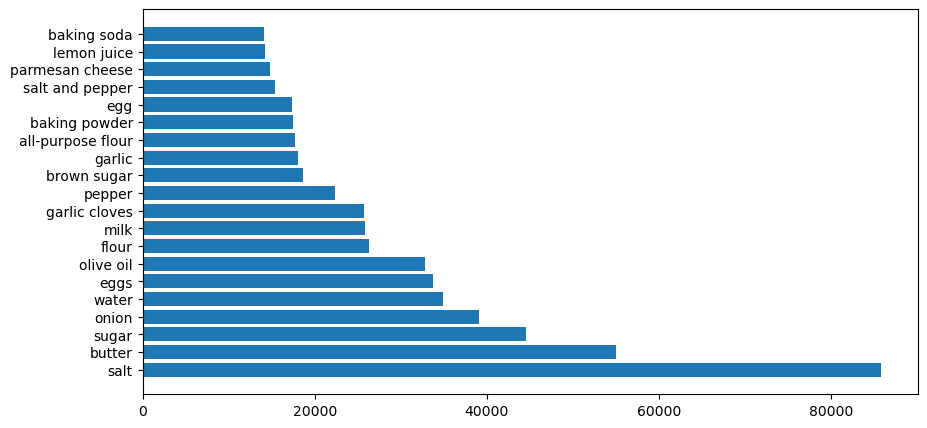

In [86]:
most_common_ingredients = ingredient_counts.most_common(20)
plt.figure(figsize=(10, 5))
plt.barh([ingredient for ingredient, _ in most_common_ingredients], [count for _, count in most_common_ingredients])
plt.show()

In [87]:
counts_arr = np.array(tuple(ingredient_counts.values()))
used_only_once_count = (counts_arr < 2).sum()
used_less_than_5_count = (counts_arr < 5).sum()

print(f"{used_only_once_count / len(ingredient_counts) * 100:.2f}% of ingredients are used only in one recipe")
print(f"{used_less_than_5_count / len(ingredient_counts) * 100:.2f}% of ingredients are used in less than 5 recipes")

23.76% of ingredients are used only in one recipe
46.42% of ingredients are used in less than 5 recipes


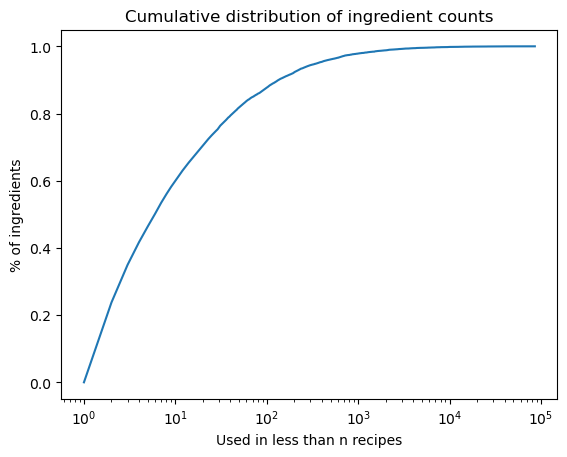

In [88]:
ing_x = [i for i in range(1, counts_arr.max() + 1)]
ing_y = [(counts_arr < i).sum() / counts_arr.shape[0] for i in ing_x]
plt.plot(ing_x, ing_y)
plt.xscale('log')
plt.title("Cumulative distribution of ingredient counts")
plt.xlabel("Used in less than n recipes")
plt.ylabel("% of ingredients")
plt.show()

Many ingredients are very sparsly used, which is a problem for our approach. They are unlikely to be useful in the prediction, but some of them might be grouped to some more general ingredients. Some examples of such ingredients are:

In [89]:
for ing in list(ingredient_counts.keys())[-10:]:
    print(ing)

low-fat low-sodium condensed cream of tomato soup
thousand island sandwich spread
pesto garlic tortillas
roasted red pepper pesto
seasoned rice vinegar with roasted garlic
apricot jell-o
rosarita premium whole black beans
hunt's fire roasted diced tomatoes
skinless halibut fillet
nepitella


#### 2.1.3. Steps

On average, each recipe has 10 steps.

In [90]:
df.n_steps.describe()

count    231637.000000
mean          9.765499
std           5.995128
min           0.000000
25%           6.000000
50%           9.000000
75%          12.000000
max         145.000000
Name: n_steps, dtype: float64

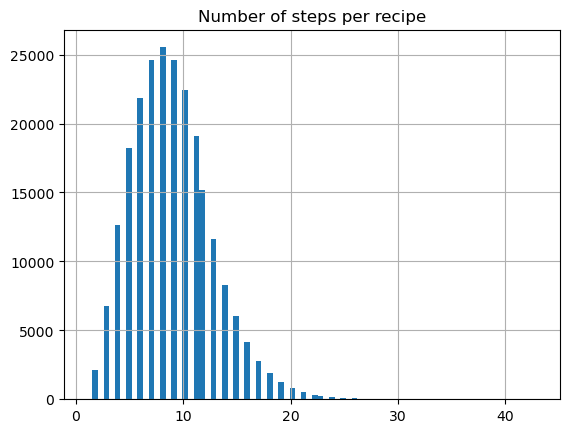

In [91]:
df.n_ingredients.hist(bins=80)
plt.title("Number of steps per recipe")
plt.show()

Example of a recipe:

In [92]:
for i, step in enumerate(steps[0]):
    print(f"{i+1:>4}. {step}")

   1. make a choice and proceed with recipe
   2. depending on size of squash; cut into half or fourths
   3. remove seeds
   4. for spicy squash; drizzle olive oil or melted butter over each cut squash piece
   5. season with mexican seasoning mix ii
   6. for sweet squash; drizzle melted honey; butter; grated piloncillo over each cut squash piece
   7. season with sweet mexican spice mix
   8. bake at 350 degrees; again depending on size; for 40 minutes up to an hour; until a fork can easily pierce the skin
   9. be careful not to burn the squash especially if you opt to use sugar or butter
  10. if you feel more comfortable; cover the squash with aluminum foil the first half hour; give or take; of baking
  11. if desired; season with salt


### 2.2. Taste Dataset

As we will want to include ingredients metadata in the component substitutes prediction, we needed a dataset that will facilitate this information.

For this reason we analyzed the [DANS - TASTE, FAT AND TEXTURE DATABASE - TASTE VALUES DUTCH FOODS](https://easy.dans.knaw.nl/ui/datasets/id/easy-dataset:195372/tab/2) dataset as it appears to be most promising, yet overall it's hard to find an extensive dataset with ingredients from the original problem, hence at later stages of the project we might resort to using a different dataset or even creating our own.


The selected dataset was compiled with the most frequently consumed foods in the Netherlands and their taste intensity relative to other available foods.
For the purposes of our program, some of the data is irrelevant and will be omitted. 

In [93]:
ingredient_df = pd.read_csv('data/ingredients_taste/Dutch_Foods.csv').fillna(0)
ingredient_df.head()

,Food_code,Product_brand,NEVO_code,Product_description_NL,Product_description_EN,Food_group_code,Food_group_NL,Food_group_EN,Date,Serving_methods,...,sd_umami,se_umami,no_salt,m_salt,sd_salt,se_salt,no_fat,m_fat,sd_fat,se_fat
0,121,AH aardappelpuree met boter,121,Aardappelpuree bereid m hv melk m marg,Potatoes mashed prep w semi-sk milk+marg,1,Aardappelen,Potatoes,26-3-2015,Served hot (>65 °C),...,10.0,3.0,10.0,44.0,9.0,3.0,10.0,36.0,15.0,5.0
1,948,Aviko Rösti rondjes naturel,948,Rosti bereid z vet,Rosti prepared without fat,1,Aardappelen,Potatoes,16-4-2015,Served hot (>65 °C),...,13.0,4.0,9.0,35.0,4.0,1.0,9.0,29.0,9.0,3.0
2,982,AH krieltjes,982,Aardappelen z schil gekookt gem,Potatoes wo skins boiled average,1,Aardappelen,Potatoes,2-12-2014,Served hot (>65 °C),...,5.0,1.0,12.0,8.0,4.0,1.0,12.0,13.0,8.0,2.0
3,1150,AH Aardappelschijfjes,1150,Aardappelschijfjes diepvries onbereid,Potatoes sliced frozen unprepared,1,Aardappelen,Potatoes,5-3-2015,Served hot (>65 °C),...,15.0,5.0,7.0,26.0,10.0,4.0,7.0,45.0,18.0,7.0
4,1456,Aviko Pommes Frites,1456,Frites voorgebakken onbereid,Chips pre-fried unprepared,1,Aardappelen,Potatoes,22-1-2015,Served hot (>65 °C),...,6.0,2.0,9.0,15.0,6.0,2.0,9.0,42.0,18.0,6.0


#### 2.2.1. Column Description

The dataset consists of products described by the following features:
- **Food_code** - Food code, as much as possible based on the nevocode
- **Product_brand** - Product tested
- **NEVO_code** - Corresponding NEVO code (0=no NEVO code)
- **Product_description_NL** - Product description for the nevocode, in Dutch
- **Product_description_EN** - Product description for the nevocode, in English
- **Food_group_code** - Food group code
- **Food_group_NL** - Food group in Dutch
- **Food_group_EN** - Food group in English
- **Date** - Date of profiling
- **Serving_methods** - Standardized serving methods (temperature, with or without crust, etc.)
- **Preparation_method** - Standardized preparation method for cooked foods
- **Reference_control_foods** - Reference foods (=1) and control foods (=2)

For each five basic tastes (sweet, sour, bitter, umami, salt) and also fat:
- **no_taste** - Number of panellists for *taste*
- **m_taste** - Mean taste intensity value for *taste*
- **sd_taste** - Standard deviation for the mean taste *taste* intensity value
- **se_taste**- Standard error for the mean taste *taste* intensity value

For our program we need only *taste* data with product description and food group.

In [94]:
ingredient_df = ingredient_df.drop(columns = ['Reference_control_foods', 'Food_code', 'Product_brand', 'NEVO_code', 'Product_description_NL','Food_group_code', 'Food_group_NL', 'Date', 'Serving_methods', 'Preparation_method', 'no_sweet', 'no_sour', 'no_bitter', 'no_umami', 'no_fat', 'no_salt'])
value_taste_columns = ['m_sweet', 'm_sour', 'm_bitter', 'm_umami', 'm_fat', 'm_salt']
print(f'There are {ingredient_df.shape[0]} different products')

There are 627 different products


#### 2.2.2. Food groups

There are 23 different food groups in the dataset


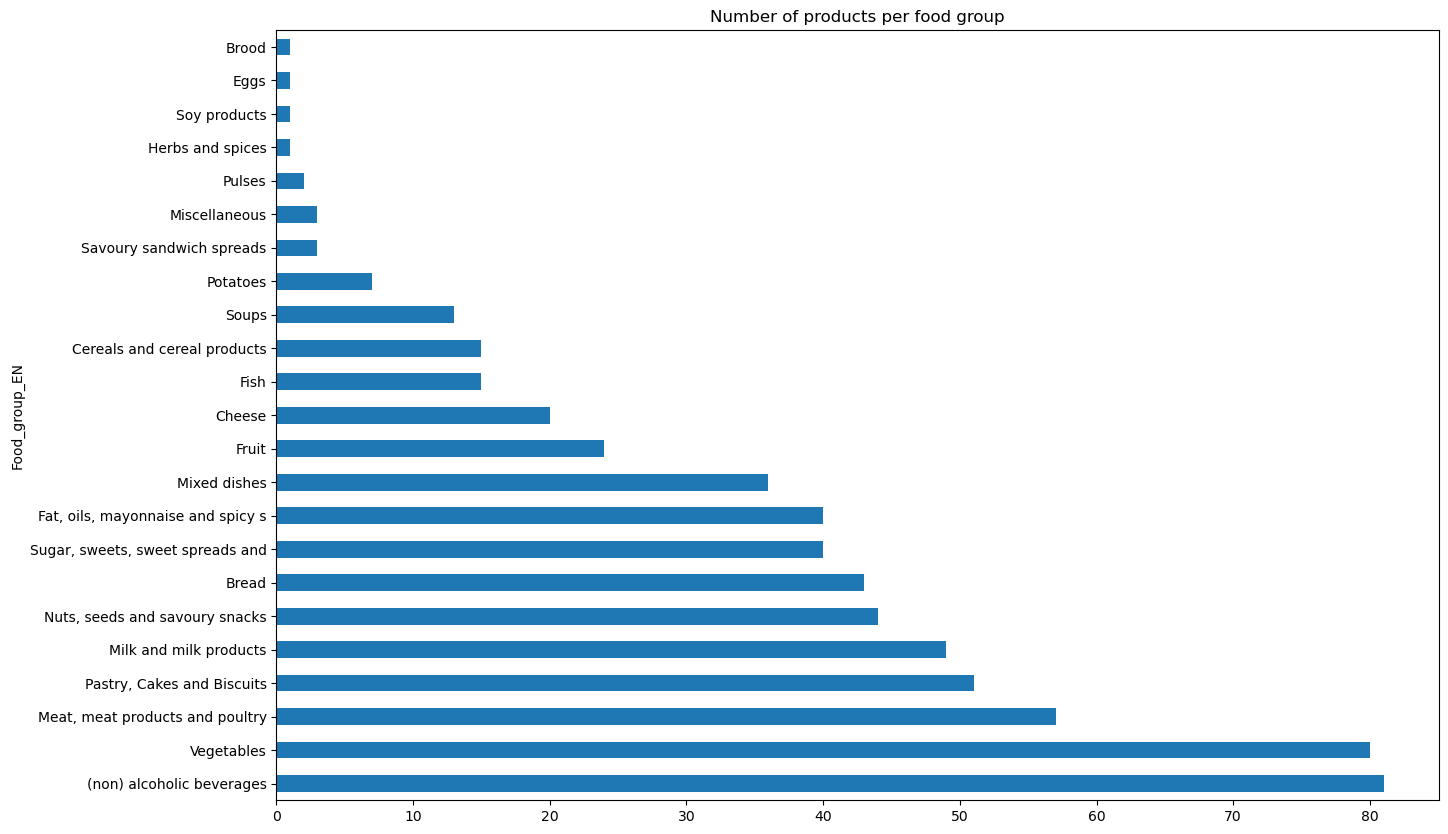

In [95]:
print(f"There are {len(ingredient_df.groupby('Food_group_EN'))} different food groups in the dataset")
ingredient_df.groupby('Food_group_EN').count()['Product_description_EN'].sort_values(ascending=False).plot.barh(figsize = (15, 10))
plt.title('Number of products per food group')
plt.show()

Four groups have only one product. This gives a very big contrast when comparing to a group of almost 80 different products of vegetables and (non) alcoholic beverages.

#### 2.2.3. Taste

In [96]:
ingredient_df.filter(items = value_taste_columns).describe()

,m_sweet,m_sour,m_bitter,m_umami,m_fat,m_salt
count,627.000000,627.000000,627.000000,627.000000,627.000000,627.000000
mean,20.510367,10.969697,4.881978,7.405104,28.068581,15.287081
std,19.488453,14.243009,10.859491,10.820870,24.113948,16.538286
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,2.000000,1.000000,1.000000,7.000000,3.000000
50%,11.000000,5.000000,1.000000,2.000000,23.000000,9.000000
75%,35.000000,15.000000,4.000000,11.500000,44.000000,25.000000
max,88.000000,97.000000,74.000000,86.000000,98.000000,94.000000


Each product was rated on a scale of 0 to 100 for each of the tastes. Most products have a high value of only one of the tastes (rarely two).

In [97]:
for taste in value_taste_columns:
    product = ingredient_df.sort_values(taste).tail(1)[['Product_description_EN', taste]]
    print(f"The most {taste[2:]} product was {product['Product_description_EN'].values[0]} with value {int(product[taste].values[0])}.")

The most sweet product was Condensed milk with value 88.
The most sour product was Juice lemon with value 97.
The most bitter product was Onion juice with value 74.
The most umami product was Soy sauce Kikkoman with value 86.
The most fat product was Oil olive with value 98.
The most salt product was Soy sauce Kikkoman with value 94.


### 2.3. Summary

The structure of the original dataset will for sure be useful in our approach, as the ingredients are given in a uniform way, which will allow us to group them into more general groups and simplify the problem.

After the grouping we should be able to use at least part of the taste dataset to enrich the information about the ingredients.

Our main concern is that that taste dataset is relatively small: only 627 products, whereas the original dataset consists of almost 15k - even after simplification, it's likely we'll have missing metadata for some ingredients.

For this reason we might switch to a different dataset or even create our own if we find it necessary.

## 3. Data Preparation - Exploring Approaches

As a part of our project, we need to recategorize the ingredients to their simplest form. We tried two approaches - AI-based and rule-based.
We also discarded the ingredients that could not be recategorized.

### 3.1. Ingredients categorization by GPT-3.5 turbo model

To facilitate AI-based categorization we decided to use OpenAI's GPT-3.5 turbo model using their API.

This solution allowed us to quickly obtained the results of decent quality.
The drawback however is that this approach is not reproducible and each run of the script will yield slightly different results (even with fixed seed and temperature = 0).

#### 3.1.1. Loading the categories

In [98]:
CATEGORIZED_INGREDIENTS_PATH = "./processed/categorized.json"
BAD_CATEGORY = "unknown"

with open(CATEGORIZED_INGREDIENTS_PATH) as f:
    categorized_ingredients: dict = json.load(f)

categorized_ingredients.pop(BAD_CATEGORY, None)
categorized_ingredients = {k.lower(): v for k, v in categorized_ingredients.items() if v != BAD_CATEGORY}

failed = [
    ingredient
    for ingredient in ingredient_counts.keys()
    if ingredient not in categorized_ingredients
]
print(f"Failed to categorize {len(failed)} ingredients")

Failed to categorize 396 ingredients


Due to the way GPT-3.5 turbo model works, some ingredients were not processed by the model - either skipped or processed incorrectly. We decided to discard these ingredients.

In [165]:
failed[-10:]

['petroleum jelly',
 'fruit salt',
 "sachet d'espices",
 'baby dou miao',
 'saba',
 'tom collins mix',
 'bear meat',
 'boar',
 'yabbies',
 'kala namak']

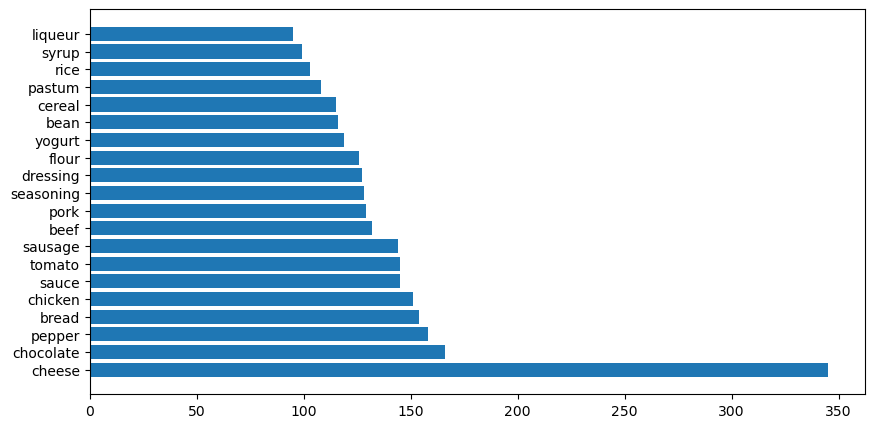

In [100]:
counted_categories = collections.Counter(categorized_ingredients.values())
most_common = counted_categories.most_common(20)

plt.figure(figsize=(10, 5))
plt.barh([category for category, _ in most_common], [count for _, count in most_common])
plt.show()

#### 3.1.2. Loss of data analysis

In [101]:
num_categories = len(counted_categories)
num_ingredients = len(ingredient_counts)

print("Total number of categories:", num_categories)
print("Total number of ingredients:", num_ingredients)
print(f"Reduction in number of ingredients to: {num_categories / num_ingredients * 100:.2f}% of original size")

Total number of categories: 2642
Total number of ingredients: 14917
Reduction in number of ingredients to: 17.71% of original size


In [102]:
ai_recategorized_ingredients = [
    categorized_ingredients[ingredient]
    for ingredient in itertools.chain.from_iterable(ingredients)
    if ingredient in categorized_ingredients
]

len(ai_recategorized_ingredients)
print(f"Retained {len(ai_recategorized_ingredients) / df['n_ingredients'].sum() * 100:.2f}% of ingredients usage")

Retained 99.15% of ingredients usage


#### 3.1.3. Recategorization results

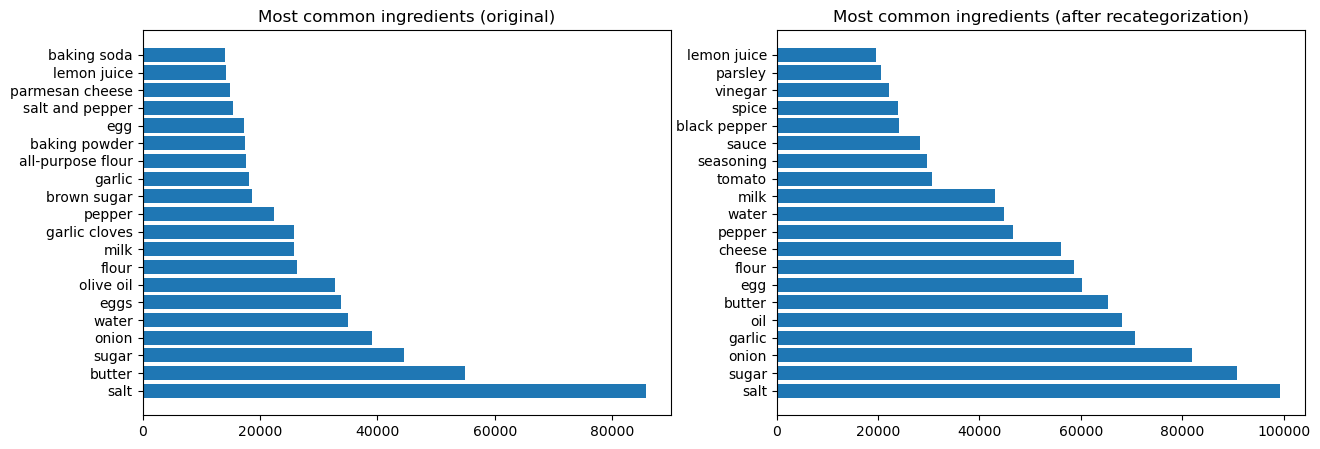

In [103]:
ingredient_recounts = collections.Counter(ai_recategorized_ingredients)
most_common_ingredients_recategorized = ingredient_recounts.most_common(20)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].barh([ingredient for ingredient, _ in most_common_ingredients], [count for _, count in most_common_ingredients])
axs[0].set_title("Most common ingredients (original)")
axs[1].barh([ingredient for ingredient, count in most_common_ingredients_recategorized if count > 1000], [count for ingredient, count in most_common_ingredients_recategorized if count > 1000])
axs[1].set_title("Most common ingredients (after recategorization)")
plt.show()

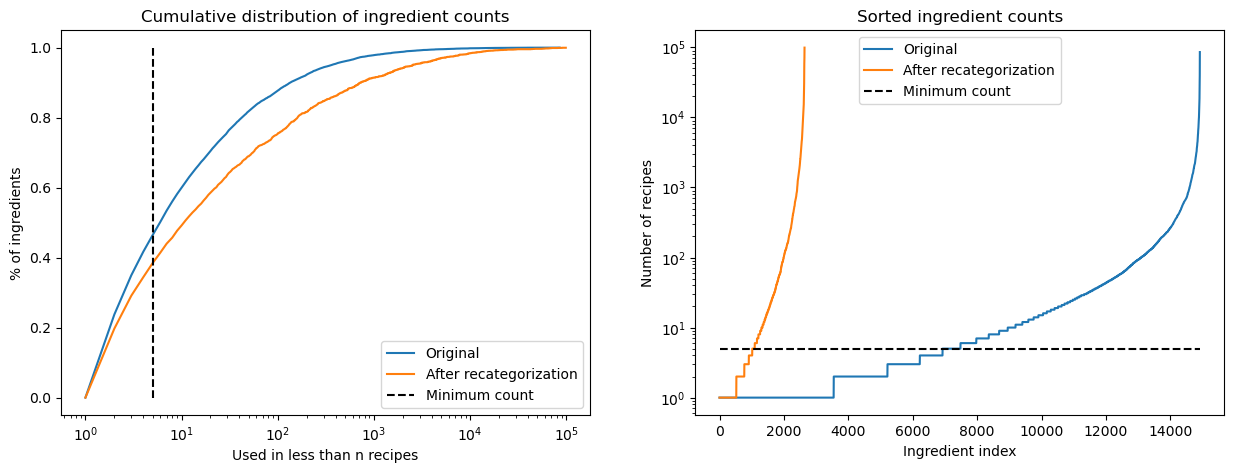

In [104]:
MIN_RECIPIES_COUNT = 5

re_counts_arr = np.array(tuple(ingredient_recounts.values()))
re_ing_x = [i for i in range(1, re_counts_arr.max() + 1)]
re_ing_y = [(re_counts_arr < i).sum() / re_counts_arr.shape[0] for i in re_ing_x]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(ing_x, ing_y, label="Original")
axs[0].plot(re_ing_x, re_ing_y, label="After recategorization")
axs[0].plot([MIN_RECIPIES_COUNT, MIN_RECIPIES_COUNT], [0, 1], label="Minimum count", linestyle="--", color="black")
axs[0].set_xscale('log')
axs[0].set_title("Cumulative distribution of ingredient counts")
axs[0].set_xlabel("Used in less than n recipes")
axs[0].set_ylabel("% of ingredients")
axs[0].legend()

axs[1].plot(sorted(counts_arr), label="Original")
axs[1].plot(sorted(re_counts_arr), label="After recategorization")
axs[1].plot([0, counts_arr.shape[0]], [MIN_RECIPIES_COUNT, MIN_RECIPIES_COUNT], label="Minimum count", linestyle="--", color="black")
axs[1].set_title("Sorted ingredient counts")
axs[1].set_xlabel("Ingredient index")
axs[1].set_ylabel("Number of recipes")
axs[1].legend()
axs[1].set_yscale('log')

plt.show()

In [105]:
parsed_min_count = [(v, count) for v, count in ingredient_counts.most_common() if count >= MIN_RECIPIES_COUNT]
ai_parsed_min_recount = [(v, count) for v, count in ingredient_recounts.most_common() if count >= MIN_RECIPIES_COUNT]

print(f"Number of ingredients with at least {MIN_RECIPIES_COUNT} recipes:")
print(f"Original: {len(parsed_min_count)}")
print(f"After recategorization: {len(ai_parsed_min_recount)}")
print(f"Reduction: {len(ai_parsed_min_recount) / len(parsed_min_count) * 100:.2f}%")

Number of ingredients with at least 5 recipes:
Original: 7992
After recategorization: 1626
Reduction: 20.35%


#### 3.1.4. Summary

Recategorization by GPT-3.5 turbo model was a good starting point, but it was not perfect. It managed to reduce the number of ingredients from 15k to 3k overall, and from 8k to 2k valid frequently used enough ones, but this is still a lot of ingredients to work with - much more than the number of entries in the taste dataset.

With this approach it will be necessary to create our own dataset with ingredients and their metadata.

### 3.2. Ingredients categorization by analytical method

As an alternative to using advanced AI, we also decided to use the analytical method of grouping components based on the noun used in it. 

#### 3.2.1 Prepare group with key words

Ingredients as keywords grouped into several categories. Created based on the most frequent nouns in the dataset.

In [106]:
from report_utils import grouping

with open('./processed/grouping.json') as f:
    ing_grouping = json.load(f)

#### 3.2.2. Splite complex ingredients

In a dataset there are several ingredients that appear as a combination of two three or even four different elements in fact such ingredients can be separated into their subcomponents. 

In [107]:
for ingredient in ingredient_counts:
    if " and " in ingredient and " with " in ingredient:
        print(ingredient)

spreadable cheese with garlic and herbs
stove top stuffing mix monterey style with mushroom and onion
diced tomatoes with chiles and cilantro
light spreadable cheese with garlic and herbs
chili with chicken and beans
diced tomatoes with basil oregano and garlic
stewed tomatoes with peppers and celery
stewed tomatoes with basil and garlic
diced tomatoes with basil and garlic
diced tomatoes with balsamic vinegar basil and oil
sazon goya with coriander and annatto
feta cheese with garlic and herbs
cream cheese with garlic and herbs
tomato sauce with basil garlic and oregano
tomatoes with onion and garlic
cream cheese with chives and onions
stir-fry sauce with garlic and ginger
diced tomatoes with sweet onions and roasted garlic
diced tomatoes with basil and oregano
multi-grain flakes cereal with oat clusters cranberries and almonds
frozen hash browns with onions and peppers
feta cheese with dried basil and tomato
frozen roasted potatoes with broccoli and cheese sauce
prego pasta sauce wit

In [108]:
separator_words = [" and ", " or ", " with ", " & ", " in "]
formula = grouping.create_formula(separator_words)

splited_ingredient = {}
for ingredient in ingredient_counts:
    for word in grouping.split_ingriedents(ingredient, formula):
        if word in splited_ingredient.keys():
            splited_ingredient[word] += 1
        else:
            splited_ingredient[word] = 1

In [109]:
print(f"Number of ingredients before split: {len(ingredient_counts)}")
print(f"Number of ingredients after split: {len(splited_ingredient)}")

Number of ingredients before split: 14917
Number of ingredients after split: 14756


#### 3.2.3. Grouping by the categories

In [110]:
ingredient_map = grouping.group_ingredients(splited_ingredient.keys(), ing_grouping)

#### 3.2.4. Recategorization results

In [111]:
print(ingredient_map["sauce_group"]["ketchup"])
print(ingredient_map["herbs_group"]["oregano"])
print(ingredient_map["others_group"]["foil"])

['ketchup', 'no-salt-added ketchup', 'tomato ketchup', 'delmonte ketchup', 'heinz ketchup', 'sodium-free ketchup', 'gluten-free ketchup', 'hot ketchup', 'low-carb ketchup', 'reduced sodium ketchup', 'low-sugar low-sodium ketchup', 'no-sugar-added ketchup', 'banana ketchup', 'low sodium ketchup', 'unsweetened ketchup', 'low-sugar ketchup']
['dried oregano', 'oregano', 'oregano leaves', 'fresh oregano', 'oregano flakes', 'ground oregano', 'dried oregano leaves', 'basil oregano', 'greek oregano', 'dry oregano', 'oregano sprig', 'powdered oregano', 'whole leaf oregano', 'dry oregano leaves', 'oregano sprigs', 'leaf oregano', 'oregano salad dressing', 'dried greek oregano', 'dried mediterranean oregano']
['aluminum foil', 'reynolds wrap foil', 'gold leaf foil', 'foil liners', 'edible silver foil']


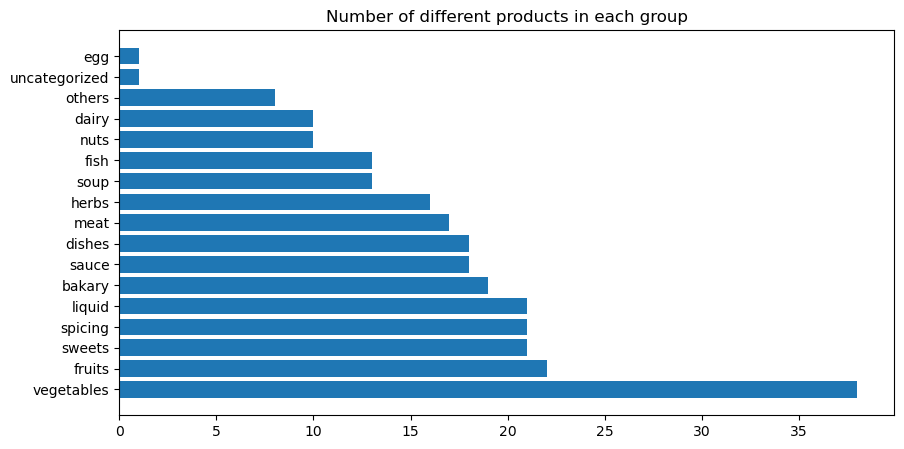

In [112]:
group_list = [[len(group.keys()), key_group] for key_group, group in ingredient_map.items()]
group_list.sort(reverse=True)
plt.figure(figsize=(10, 5))
plt.barh([name.split("_")[0] for _, name in group_list], [counts for counts, _ in group_list])
plt.title("Number of different products in each group")
plt.show()

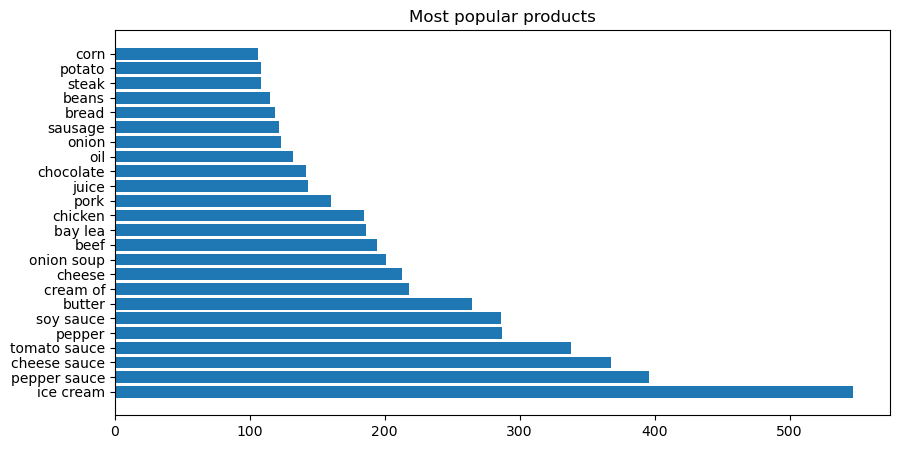

In [113]:
product_list = []
for product in ingredient_map.values():
    for key, products in product.items():
        product_list.append([len(products), key])
product_list.sort(reverse=True)
plt.figure(figsize=(10, 5))
plt.barh([name for _, name in product_list[1:25]], [counts for counts, _ in product_list[1:25]])
plt.title("Most popular products")
plt.show()


#### 3.2.5 Uncategorized products

In [114]:
uncategorized = len(ingredient_map["uncategorized"]["uncategorized"])
print(f"Number of uncategorized ingredients: {uncategorized}")

Number of uncategorized ingredients: 2434


In [115]:
invert_map = {
    ingredient: key
    for key, group in ingredient_map.items()
    for _, ingredients in group.items()
    for ingredient in ingredients
}

In [116]:
invert_map = grouping.invert_grouping(ingredient_map)

rule_recategorized_ingredients = [
    invert_map[ingredient]
    for ingredient in itertools.chain.from_iterable(ingredients)
    if ingredient in invert_map and invert_map[ingredient] != "uncategorized"
]

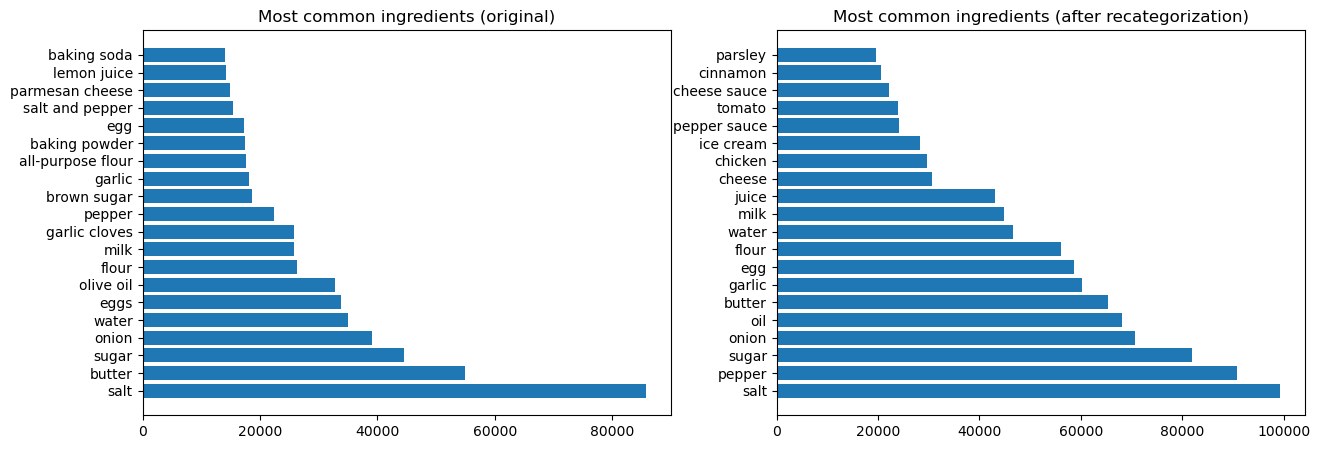

In [117]:
ingredient_rule_recounts = collections.Counter(rule_recategorized_ingredients)
most_common_ingredients_rule_recategorized = ingredient_rule_recounts.most_common(20)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].barh([ingredient for ingredient, _ in most_common_ingredients], [count for _, count in most_common_ingredients])
axs[0].set_title("Most common ingredients (original)")
axs[1].barh([ingredient for ingredient, count in most_common_ingredients_rule_recategorized if count > 1000], [count for ingredient, count in most_common_ingredients_recategorized if count > 1000])
axs[1].set_title("Most common ingredients (after recategorization)")
plt.show()

#### 3.2.6. Comparison with baseline and previous approach

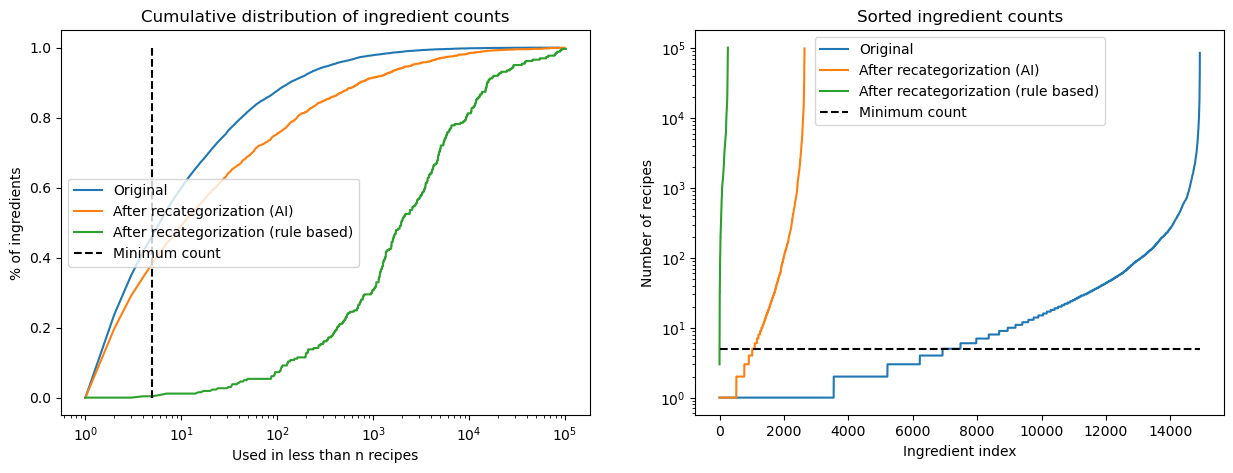

In [118]:
rule_re_counts_arr = np.array(tuple(ingredient_rule_recounts.values()))
rule_re_ing_x = [i for i in range(1, rule_re_counts_arr.max() + 1)]
rule_re_ing_y = [(rule_re_counts_arr < i).sum() / rule_re_counts_arr.shape[0] for i in rule_re_ing_x]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(ing_x, ing_y, label="Original")
axs[0].plot(re_ing_x, re_ing_y, label="After recategorization (AI)")
axs[0].plot(rule_re_ing_x, rule_re_ing_y, label="After recategorization (rule based)")
axs[0].plot([MIN_RECIPIES_COUNT, MIN_RECIPIES_COUNT], [0, 1], label="Minimum count", linestyle="--", color="black")
axs[0].set_xscale('log')
axs[0].set_title("Cumulative distribution of ingredient counts")
axs[0].set_xlabel("Used in less than n recipes")
axs[0].set_ylabel("% of ingredients")
axs[0].legend()

axs[1].plot(sorted(counts_arr), label="Original")
axs[1].plot(sorted(re_counts_arr), label="After recategorization (AI)")
axs[1].plot(sorted(rule_re_counts_arr), label="After recategorization (rule based)")
axs[1].plot([0, counts_arr.shape[0]], [MIN_RECIPIES_COUNT, MIN_RECIPIES_COUNT], label="Minimum count", linestyle="--", color="black")
axs[1].set_title("Sorted ingredient counts")
axs[1].set_xlabel("Ingredient index")
axs[1].set_ylabel("Number of recipes")
axs[1].legend()
axs[1].set_yscale('log')

plt.show()

Numbr of ingredients after recategorization:

In [119]:
len(ingredient_rule_recounts)

261

In [120]:
rule_parsed_min_recount = [(v, count) for v, count in ingredient_rule_recounts.most_common() if count >= MIN_RECIPIES_COUNT]

print(f"Number of ingredients with at least {MIN_RECIPIES_COUNT} recipes:")
print(f"Original: {len(parsed_min_count)}")
print(f"After recategorization: {len(rule_parsed_min_recount)}")
print(f"Reduction: {len(rule_parsed_min_recount) / len(parsed_min_count) * 100:.2f}%")

Number of ingredients with at least 5 recipes:
Original: 7992
After recategorization: 260
Reduction: 3.25%


#### 3.2.7. Summary

The second approach brings down the number of much more substantially, down to 250 ingredients. This is a much more manageable number, but it's still a lot more than the number of entries in the taste dataset.

Moreover this method omits almost 1k ingredients, which is a lot of data to lose.

### 3.3. Conclusion from data preparation

Both approaches have their pros and cons. The AI-based approach is much more flexible and can be easily extended to include more categories, but it's not reproducible and the results are not always the same. The analytical approach is much more stable, but it's not as flexible and requires manual work to create the categories.

Analyzing the results of AI approach more deeply we may still observe some redundancy, such as having separate categories for "beef" and "roasted beef" and having several ingredients split into their singular and plural form.

Henceforth we decided to apply extended analytical method on the results of AI-based approach to get the best of both worlds.


## 4. Data Preparation - Combining both methods

### 4.1. Applying analytical method on the results of AI-based approach

As stated in the previous section, we decided to apply the analytical method on the results of AI-based approach to get the best of both worlds.

Whilst this leads to less ingredients than the analytical method alone, the final result is of better quality.

In [121]:
categorized_ingredients

{'8-grain bread': 'bread',
 'strawberry whipped topping': 'topping',
 'horseradish mayonnaise': 'mayonnaise',
 'canned blueberries': 'blueberry',
 'hot pepper oil': 'oil',
 'fine dry white bread crumbs': 'bread crumb',
 'boneless pork top loin': 'pork',
 'hemp milk': 'milk',
 'tomato beef soup mix': 'soup mix',
 'dried prunes': 'prune',
 'cheddar bratwursts': 'sausage',
 'cauliflower floret': 'cauliflower',
 '8-inch pre-baked crumb crust': 'crust',
 'corn on the cob': 'corn',
 'cranberry-cinnamon bread': 'bread',
 'caffeine-free instant coffee': 'coffee',
 'unsweetened cranberry juice': 'juice',
 'rye whiskey': 'whiskey',
 'grilled chicken breast': 'chicken',
 'frangelico': 'liqueur',
 'salted sunflower seeds': 'seed',
 'malt syrup': 'syrup',
 'hickory chips': 'chip',
 'tart cooking apple': 'apple',
 'banana nut crunch cereal': 'cereal',
 'fresh tortellini': 'tortellini',
 'fresh thyme': 'thyme',
 'rosemary bread': 'bread',
 'egg roll wrappers': 'wrapper',
 'dried sorrel': 'sorrel',
 '

In [122]:
len(set(categorized_ingredients.values()))

2642

In [123]:
final_grouping = grouping.group_ingredients(categorized_ingredients.values(), ing_grouping)
len(final_grouping["uncategorized"]["uncategorized"])

3895

In [124]:
final_inversed_map = categorized_ingredients.copy()
for ingredient, group in final_inversed_map.items():
    final_inversed_map[ingredient] = grouping.find_group(group, final_grouping)

In [125]:
for ingredient, group in final_inversed_map.items():
    if (group == "uncategorized"):
        final_inversed_map[ingredient] = grouping.find_group(ingredient, ing_grouping)

In [126]:
for ingredient in set(final_grouping['uncategorized']['uncategorized']):
    print(f"{ingredient:<20} {counted_categories[ingredient]:>4}")

rava                    1
passatum                1
prune puree             1
frankfurter             7
zinfandel               1
calvado                 1
nixtamal                1
mirepoix                2
stew                    2
asparagu               12
gatorade                2
amchur                  1
mead                    1
daiquiri mix            1
pimento                 3
mutton                  7
acorn                   2
redfish                 1
screwpine leafe         1
cream                  39
muffin mix             15
frank                   2
masala                  6
sea scallop             1
dry rub                 1
boston cream roll       1
kahlua                  1
rib rack                1
phyllo sheet            1
kudzu                   1
fiddlehead              1
walnut half             1
bite                    1
chard leafe             2
tender                  1
fondant                 2
orecchiette             1
bouquet garni           1
lasagna shee

In [127]:
final_rule_recategorized_ingredients = [
    final_inversed_map[ingredient]
    for ingredient in itertools.chain.from_iterable(ingredients)
    if ingredient in final_inversed_map and final_inversed_map[ingredient] != "uncategorized"
]

### 4.2. Recategorization results

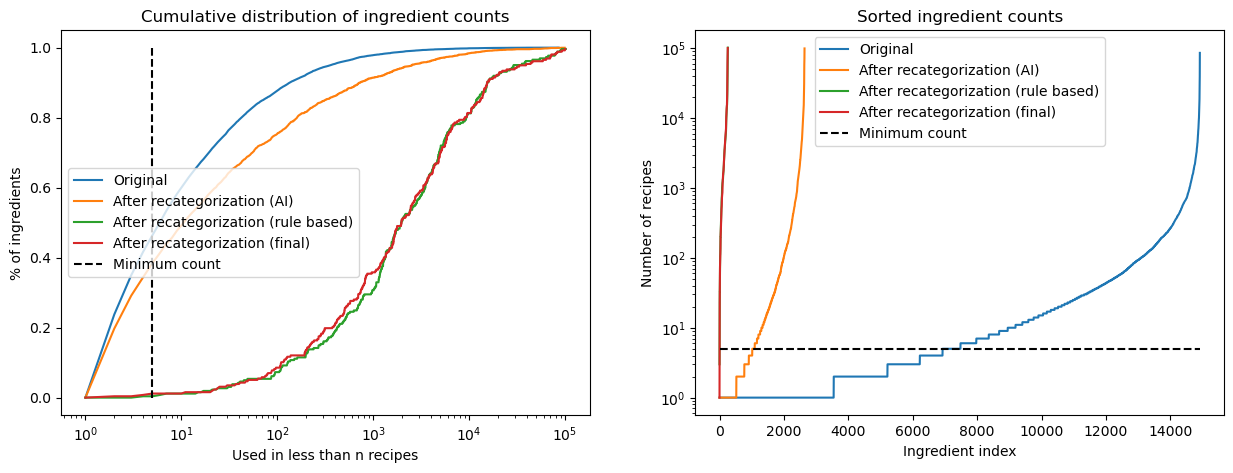

In [128]:
ingredient_final_recounts = collections.Counter(final_rule_recategorized_ingredients)

final_re_counts_arr = np.array(tuple(ingredient_final_recounts.values()))

final_ing_x = [i for i in range(1, final_re_counts_arr.max() + 1)]
final_ing_y = [(final_re_counts_arr < i).sum() / final_re_counts_arr.shape[0] for i in final_ing_x]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(ing_x, ing_y, label="Original")
axs[0].plot(re_ing_x, re_ing_y, label="After recategorization (AI)")
axs[0].plot(rule_re_ing_x, rule_re_ing_y, label="After recategorization (rule based)")
axs[0].plot(final_ing_x, final_ing_y, label="After recategorization (final)")
axs[0].plot([MIN_RECIPIES_COUNT, MIN_RECIPIES_COUNT], [0, 1], label="Minimum count", linestyle="--", color="black")
axs[0].set_xscale('log')
axs[0].set_title("Cumulative distribution of ingredient counts")
axs[0].set_xlabel("Used in less than n recipes")
axs[0].set_ylabel("% of ingredients")
axs[0].legend()

axs[1].plot(sorted(counts_arr), label="Original")
axs[1].plot(sorted(re_counts_arr), label="After recategorization (AI)")
axs[1].plot(sorted(rule_re_counts_arr), label="After recategorization (rule based)")
axs[1].plot(sorted(final_re_counts_arr), label="After recategorization (final)")
axs[1].plot([0, counts_arr.shape[0]], [MIN_RECIPIES_COUNT, MIN_RECIPIES_COUNT], label="Minimum count", linestyle="--", color="black")
axs[1].set_title("Sorted ingredient counts")
axs[1].set_xlabel("Ingredient index")
axs[1].set_ylabel("Number of recipes")
axs[1].legend()
axs[1].set_yscale('log')

plt.show()

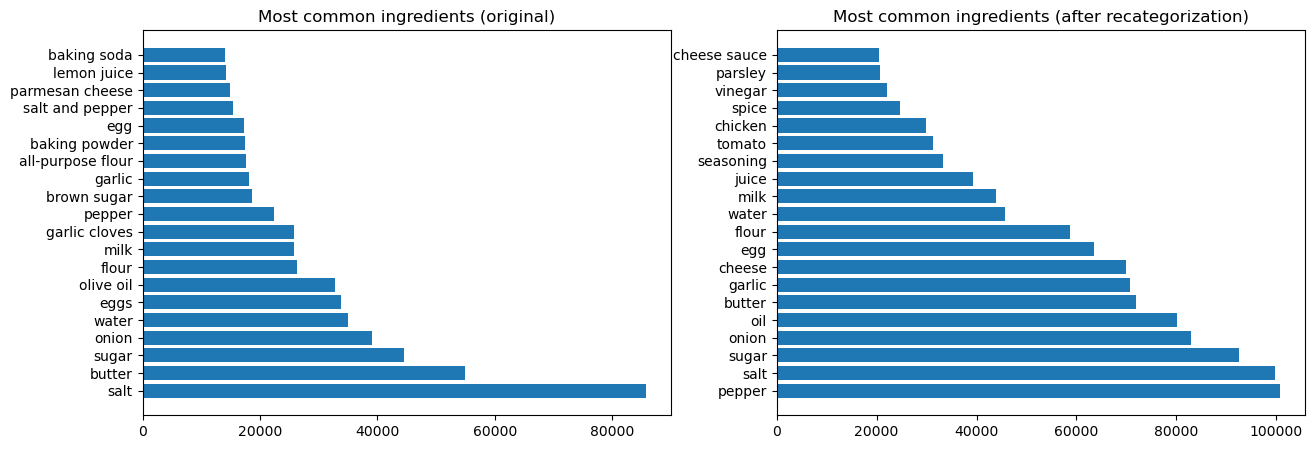

In [129]:
# most common ingredients recategorized

most_common_ingredients_recategorized = ingredient_final_recounts.most_common(20)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].barh([ingredient for ingredient, _ in most_common_ingredients], [count for _, count in most_common_ingredients])
axs[0].set_title("Most common ingredients (original)")
axs[1].barh([ingredient for ingredient, count in most_common_ingredients_recategorized if count > 1000], [count for ingredient, count in most_common_ingredients_recategorized if count > 1000])
axs[1].set_title("Most common ingredients (after recategorization)")
plt.show()

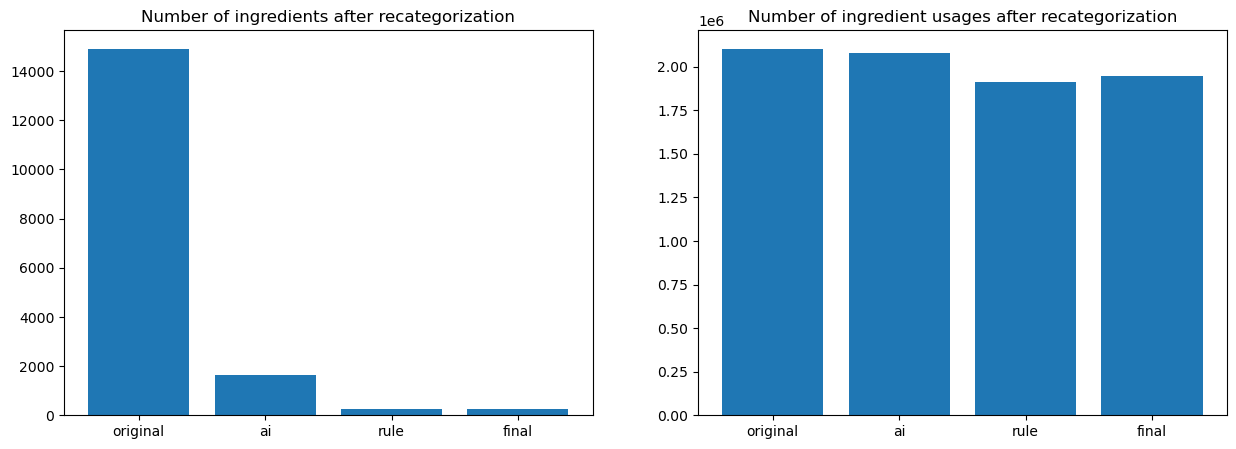

In [130]:
categories_reduction = {
    "original": len(ingredient_counts),
    "ai": len(ai_parsed_min_recount),
    "rule": len(rule_parsed_min_recount),
    "final": len(ingredient_final_recounts)
}

usage_reduction = {
    "original": sum(ingredient_counts.values()),
    "ai": sum(dict(ai_parsed_min_recount).values()),
    "rule": sum(dict(rule_parsed_min_recount).values()),
    "final": sum(ingredient_final_recounts.values())
}

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].bar(categories_reduction.keys(), categories_reduction.values())
axs[0].set_title("Number of ingredients after recategorization")

axs[1].bar(usage_reduction.keys(), usage_reduction.values())
axs[1].set_title("Number of ingredient usages after recategorization")
plt.show()


In [131]:
with open("./processed/final_recategorized.json", 'w') as f:
    json.dump(list(ingredient_final_recounts.keys()), f)

### 4.3. Conclusion from preparation final recategorization

Final datasets for grouping ingredients was created by weaving a map between the groups proposed by AI and the groups created by lexical analysis. In this way, it was possible to combine the most important advantages of both methods, that is, the small number of groups from the rule-based method and the accuracy of group prediction for a specific ingredient created with AI. <br>

In addition, the use of reusing the lexical method, for those items between which a group could not be found by combined mapping, resulted in finding the right group for even more ingredients. <br>

The dataset created in this way minimizes the number of unclustered ingredients while keeping the number of groups small. It is also worth noting that ingredients without a group are used in not a great number of recipes or are not precise (often as much that even grouping them manually is not possible).


## 5. Data Preparation - Ingredients metadata

As a part of our project, we need to enrich the ingredients with metadata. We decided to create our own dataset with ingredients and their metadata, using once again AI-based approach.

We tasked OpenAI's GPT-3.5 turbo model with generating the metadata for each ingredient, that contains the following information:
- **origin** - origin of the ingredient, one of: "animal", "plant", "other"
- **type** - type of the ingredient, one of: "raw", "processed"
- **state** - state of the ingredient, one of: "solid", "liquid", "gas"
- **texture** - texture of the ingredient, one of: "soft", "hard", "crunchy", "smooth"
- **taste** - taste of the ingredient, one of: "sweet", "sour", "bitter", "umami", "salty"
- **taste-intensity** - intensity of the taste of the ingredient, one of: "low", "medium", "high"
- **smell** - smell of the ingredient, one of: "sweet", "sour", "bitter", "umami", "salty"
- **smell-intensity** - intensity of the smell of the ingredient, one of: "low", "medium", "high"


### 5.1. Loading the metadata

In [132]:
with open("./processed/characterized.json") as f:
    characterized_ingredients_df = pd.read_json(f).T

characterized_ingredients_df.head()

,origin,type,state,texture,taste,taste-intensity,smell,smell-intensity
squash,vegetable,raw,solid,soft,other,other,other,other
seasoning,other,other,other,other,other,other,other,other
spice,other,other,other,other,other,other,other,other
honey,other,other,liquid,other,sweet,medium,sweet,medium
butter,dairy,other,solid,soft,other,other,other,other


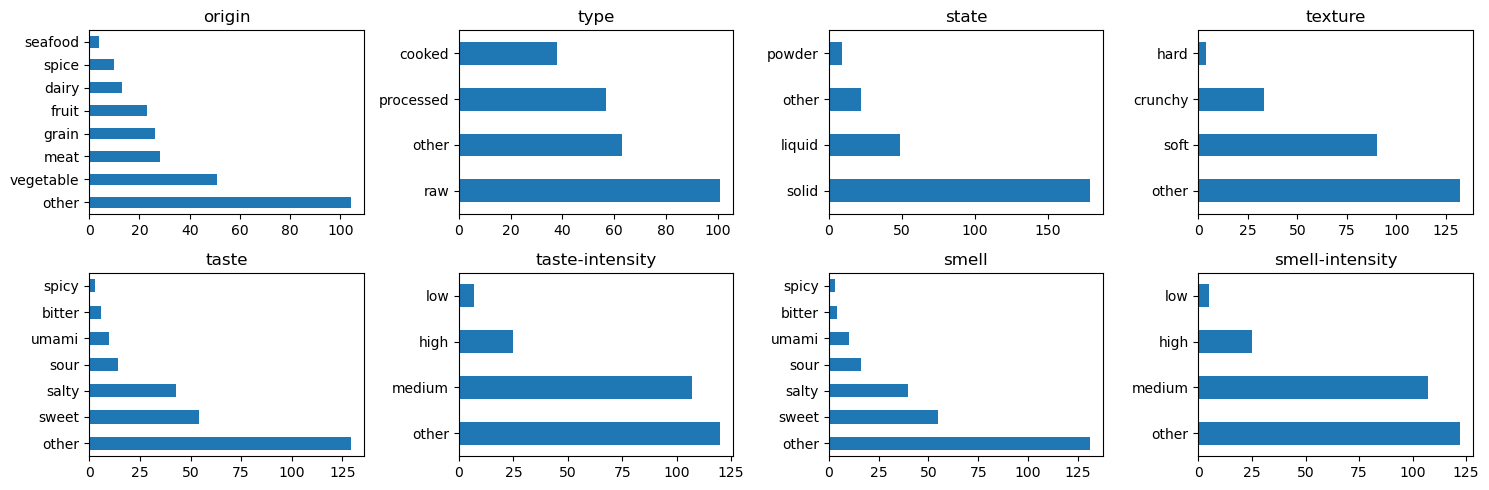

In [133]:
fig, axs = plt.subplots(2, 4, figsize=(15, 5))
for i, column in enumerate(characterized_ingredients_df.columns):
    ax = axs[i // 4, i % 4]
    characterized_ingredients_df[column].value_counts().plot.barh(ax=ax, title=column)
    ax.set_ylabel("")

plt.tight_layout() 
plt.show()

## 6. Preparing API for our adjustments

In order to make our adjustments to the original approach, we need to prepare an API that will allow us to easily access the data and perform the necessary operations.

As the authors provided only a vague script that prints out several rankings with many fixed parameters, cryptic functionalities and no documentation, we decided to write our own API for obtaining replacements.

As a benefit, we can easily optimize most computationally expensive operations, and fixing some bugs that went unnoticed by the authors (e.g. cooccurence matrix had an upper limit of 2048 ingredients which sometimes yielded invalid results).

In [134]:
import json
import numpy as np
from report_utils import graph, similarity

with open("./data/recipe_parsed_sm/ingredient_list.json") as f:
    ingredients = set(json.load(f))

with open("./data/recipe_parsed_sm/recipe_tree_data.json") as f:
    graph_tree = json.load(f)

recipe_data = graph.parse_graph_tree(graph_tree, ingredients)
recipe_data['44061']

RecipeData(graph=<networkx.classes.digraph.DiGraph object at 0x00000223254A1F00>, ingredients={'clove oil', 'jar', 'salt', 'apple cider vinegar', 'dry mustard', 'tomato juice', 'pepper', 'sugar', 'cinnamon oil'})

In [135]:
usage_counts = graph.get_ingredient_usage_counts_from_recipies(recipe_data)
usage_counts.most_common(10)

[('salt', 9563),
 ('sugar', 5291),
 ('butter', 4799),
 ('egg', 4773),
 ('onion', 4165),
 ('water', 2993),
 ('garlic clove', 2829),
 ('milk', 2525),
 ('olive oil', 2512),
 ('flour', 2409)]

### 6.1. Cooccurence matrix

No more with a limit of 2048 ingredients.

In [136]:
target_recipe = '44061'
target_ing = "pepper"

ingredients_tuple = tuple(usage_counts.keys())

ingredient_index_maping = {ingredient: i for i, ingredient in enumerate(ingredients_tuple)}
target_recipe_vector = similarity.get_recipe_ingredients_vector(recipe_data[target_recipe].ingredients, ingredient_index_maping)
cooc_matrix = similarity.calculate_cooccurence_matrix(
    (recipe.ingredients for recipe in recipe_data.values()), 
    ingredient_index_maping
)

cooc_matrix.max()

2929

### 6.2. Cosine similarity metric

As one of the rankings, the authors used cosine similarity metric. We decided to implement it as a separate function, so that we can easily use it in combination with other metrics.

In [137]:
cosine_similarities = similarity.get_cosine_similarities(cooc_matrix, ingredient_index_maping[target_ing])

most_similar = np.argsort(cosine_similarities)[::-1]

for i in most_similar[:10]:
    print(f"{ingredients_tuple[i]:<20} {cosine_similarities[i]:.3f}")

pepper               1.000
salt pepper          0.981
black pepper         0.977
salt & pepper        0.962
ground black pepper  0.957
white pepper         0.942
ground pepper        0.936
fresh ground pepper  0.932
fresh parsley        0.924
parsley              0.922


### 6.3. Cosine similarity only considering ingredients in the target recipe

Additionally to the original cosine metric, the authors also used a modified version of it, that only considers ingredients in the target recipe. We decided to implement it as a separate function, so that we can easily use it in combination with other metrics.

In [138]:
ingredient_counts_vector = np.array([usage_counts[ingredient] for ingredient in ingredients_tuple])

trgt_cosine_similarity = similarity.get_cosine_similarities_on_target_ingredients(
    cooccurence_matrix=cooc_matrix,
    ingredient_counts=ingredient_counts_vector,
    recipe_ingredients=target_recipe_vector,
    target_idx=ingredient_index_maping[target_ing]
)

most_similar = np.argsort(trgt_cosine_similarity)[::-1]

for i in most_similar[:10]:
    print(f"{ingredients_tuple[i]:<20} {trgt_cosine_similarity[i]:.3f}")


pepper               1.000
salt pepper          0.999
fresh ground pepper  0.999
cracked black pepper 0.999
salt & pepper        0.999
black pepper         0.999
salt & fresh ground pepper 0.999
salt & freshly ground black pepper 0.999
garam masala powder  0.999
salt black pepper    0.999


### 6.4. Embeddings metrics

Most important metrics are based on graph embeddings. We reused most of the code from the original script (refactoring it slightly) and obtained a result that may be easily used within a notebook

In [139]:
import pathlib
from report_utils import kgcalc, load

ent_emb, rel_emb = load.load_embedding_data(
    pathlib.Path("./data/recipe_parsed_sm/models/GraphOps_recipe_parsed_sm_graph_TransE")
)

id_to_entities = load.load_graph_data(
    pathlib.Path("./data/recipe_parsed_sm/triple_data/entities.dict")
)
entities = {v: k for k, v in id_to_entities.items()}
id_to_relations = load.load_graph_data(
    pathlib.Path("./data/recipe_parsed_sm/triple_data/relations.dict")
)
relations = {v: k for k, v in id_to_relations.items()}

kg_calculator = kgcalc.KnowledgeGraphCalculator(
    entity_embeddings=ent_emb,
    entity_id_mapping=entities,
    relation_embeddings=rel_emb,
    relation_id_mapping=relations
)

In [140]:
operations = {}
for dataset in ["test", "train", "valid"]:
    operations.update(
        load.load_json_list(pathlib.Path(f"./data/recipe_parsed_sm/triple_data/{dataset}.txt"))
    )

In [141]:
operation_target_key = f"RECIPE_OUTPUT_{target_recipe}"
ingredient_output_similarity = kg_calculator.calculate_ingredient_output_similarity(
    operations[operation_target_key],
    target_ing,
    ingredients_tuple
)

recipe_output_similarity = kg_calculator.calculate_recipe_output_similarity(
    operation_target_key,
    operations[operation_target_key],
    target_ing,
    ingredients_tuple
)

most_similar_ing_output = np.argsort(ingredient_output_similarity)[::-1]
most_similar_recipe_output = np.argsort(recipe_output_similarity)[::-1]


print("Ingredients producing most similar original calculated output")
for i in most_similar_ing_output[:10]:
    print(f"{ingredients_tuple[i]:<20} {ingredient_output_similarity[i]:.3f}")

print("\n\nIngredients producing most similar recipe's embedding output")
for i in most_similar_recipe_output[:10]:
    print(f"{ingredients_tuple[i]:<20} {recipe_output_similarity[i]:.3f}")

Ingredients producing most similar original calculated output
pepper               1.000
aleppo pepper        0.998
tabasco pepper       0.998
pimento pepper       0.998
pickled hot pepper   0.998
salt fresh pepper    0.998
red hot pepper       0.998
banana pepper        0.998
green pepper strip   0.998
cubanelle pepper     0.998


Ingredients producing most similar recipe's embedding output
clove oil            0.660
apple cider vinegar  0.650
tomato juice         0.650
dry mustard          0.649
hot dry mustard      0.649
cinnamon oil         0.649
dried lima bean      0.647
bean mix             0.646
multi grain hot cereal 0.646
chard leave          0.646


In [142]:
individual_ing_sim = kg_calculator.calculate_individual_ingredient_similarity(
    operation_target_key,
    ingredients_tuple
)

most_similar_ing_individual = np.argsort(individual_ing_sim)[::-1]

print("Ingredients producing most similar individual ingredient output")
for i in most_similar_ing_individual[:10]:
    print(f"{ingredients_tuple[i]:<20} {individual_ing_sim[i]:.3f}")

Ingredients producing most similar individual ingredient output
clove oil            0.655
apple cider vinegar  0.475
tomato juice         0.445
jar                  0.413
dry mustard          0.355
hot dry mustard      0.332
cinnamon oil         0.297
allspice berry       0.292
coleman dry mustard  0.291
brine cured black olive 0.251


## 7. Similarity between ingredients based on the generated metadata dataset

To improve the quality of the prediction, we could incorporate the metadata about individual ingredients (e.g. taste, type) and make a prediction as a combination of the two sources. The plan for us is to describe the metadata in form of a feature matrix (one-hot encoded), combine similarity metric between the missing ingredient and its alternatives, combine the metric with paper's original approach using weights, find most appropriate replacements.

In [143]:
characterized_ingriedients_onehot_df = pd.get_dummies(characterized_ingredients_df)

characterized_ingriedients_onehot_df.head()

,origin_dairy,origin_fruit,origin_grain,origin_meat,origin_other,origin_seafood,origin_spice,origin_vegetable,type_cooked,type_other,...,smell_other,smell_salty,smell_sour,smell_spicy,smell_sweet,smell_umami,smell-intensity_high,smell-intensity_low,smell-intensity_medium,smell-intensity_other
squash,False,False,False,False,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,True
seasoning,False,False,False,False,True,False,False,False,False,True,...,True,False,False,False,False,False,False,False,False,True
spice,False,False,False,False,True,False,False,False,False,True,...,True,False,False,False,False,False,False,False,False,True
honey,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,True,False
butter,True,False,False,False,False,False,False,False,False,True,...,True,False,False,False,False,False,False,False,False,True


### 7.1. Feature weights

The dataset contains 8 features, each of which is a categorical variable. Calculating similarity of two ingredients solely based on one-hot encoding might not be enough as not all of them are equally important. For example, the taste of the ingredient is much more important than its smell. For this reason we decided to assign weights to each of the features, so that the similarity metric will take them into account.

Based on our own judgement, we decided to assign the following weights to the features:

In [144]:
weights = {
    "origin": 3,
    "type": 2,
    "state": 3,
    "smell": 1,
    "smell-intensity": 1,
    "taste": 10,
    "taste-intensity": 5,
    "texture": 2,
}

for col in characterized_ingriedients_onehot_df.columns:
    col_group = col.split("_")[0]
    characterized_ingriedients_onehot_df[col] *= weights[col_group]

### 7.2. Dealing with 'other' category

All of the features did have 'other' as an option for the AI to choose. This is a problem, as it can't be compared to any other ingredient. For this reason we decided to discard all ingredients that have 'other' as a value for any of the features.

In [145]:
other_columns = [col for col in characterized_ingriedients_onehot_df.columns if "other" in col]
# drop other columns
characterized_ingriedients_onehot_df.drop(columns=other_columns, inplace=True)

### 7.3. Similarity metrics

We decided to stick to the cosine similarity metric, as it's the most popular one and it's easy to use and supports weights on the get-go.

In [146]:
from sklearn.metrics.pairwise import cosine_similarity

### 7.4. Quality evaluation

We decided to evaluate the quality of our approach by manually checking the results of the ranking on 100 pairs of ingredients. The pairs were pre-selected at random.

In [147]:
import random

random.seed(42)

ingredient_pairs = [
    random.sample(final_inversed_map.keys(), 2)
    for _ in range(100)
]

for i, (ingredient1, ingredient2) in enumerate(ingredient_pairs):
    print(f"Pair {i+1:>3}")
    print(f"\tIngredient 1: {ingredient1}")
    print(f"\tIngredient 2: {ingredient2}")
    mapped_ingredient1 = final_inversed_map[ingredient1]
    mapped_ingredient2 = final_inversed_map[ingredient2]
    if "uncategorized" in [mapped_ingredient1, mapped_ingredient2]:
        print("\tUncategorized ingredient")
        continue
    print(f"\tMapped ingredient 1: {mapped_ingredient1}")
    print(f"\tMapped ingredient 2: {mapped_ingredient2}")
    v1 = characterized_ingriedients_onehot_df.loc[mapped_ingredient1].to_numpy()
    v2 = characterized_ingriedients_onehot_df.loc[mapped_ingredient2].to_numpy()
    print(f"\tSimilarity: {cosine_similarity(v1.reshape(1, -1), v2.reshape(1, -1)).flatten()[0]:.3f}")

Pair   1
	Ingredient 1: red apple
	Ingredient 2: chocolate eggs
	Mapped ingredient 1: apple
	Mapped ingredient 2: chocolate
	Similarity: 0.752
Pair   2
	Ingredient 1: frozen cut broccoli in cheese sauce
	Ingredient 2: other italian pasta
	Mapped ingredient 1: broccoli
	Mapped ingredient 2: pasta
	Similarity: 0.376
Pair   3
	Ingredient 1: orange flavoring
	Ingredient 2: no-sugar-added applesauce
	Mapped ingredient 1: flavoring
	Mapped ingredient 2: apple
	Similarity: 0.000
Pair   4
	Ingredient 1: mange-touts peas
	Ingredient 2: chipotle hot sauce
	Mapped ingredient 1: pea
	Mapped ingredient 2: cheese sauce
	Similarity: 0.000
Pair   5
	Ingredient 1: fat free pina colada yogurt
	Ingredient 2: barbecue sauce concentrate
	Mapped ingredient 1: yogurt
	Mapped ingredient 2: barbecue sauce
	Similarity: 0.072
Pair   6
	Ingredient 1: refrigerated white chocolate chip macadamia nut cookie dough
	Ingredient 2: ginger syrup
	Mapped ingredient 1: cookie
	Mapped ingredient 2: syrup
	Similarity: 0.717


C:\Users\Endrj\AppData\Local\Temp\ipykernel_13504\2668961365.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(final_inversed_map.keys(), 2)


Quality evaluation shows that the metadata dataset with adjusted feature weights does provide better than random results. Due to our exclusion of "Other" category for all features, most pairs vere classified as completely different (0 or nan). This is expected as it is the case for most of the ingredients in the dataset. Many pairs classified as similar were in fact similar, e.g.:
- **6-inch whole wheat pitas** and **twelve-grain bread** (0.753)
- **lightlife gimme lean ground sausage** and **pork shoulder blade roast** (0.818)
- **halibut steaks** and **new york strip steak** (1.000)

A curious side effect was high similarity between ingredients that while not being similar in taste, are often used in similar recipes, e.g.:
- **chocolate almond bark** and **reduced-fat pie crusts** (0.958)
- **raspberry jelly** and **pepperidge farm chessmen cookie** (0.943)

There were also some mismatches, e.g.:
- **ground paprika** and **tempura flour** (0.591)
- **watermelon balls** and **camomile tea** (1.000)

The above shows that while the dataset does not provide enough information on its own to be used for ranking, it can be used to improve the results of the original approach.

### 7.5. Example: ranking of substitutes for chicken

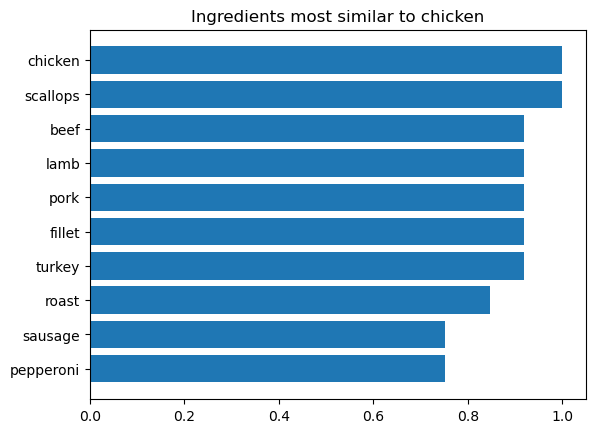

In [148]:
# example: closest to chicken

chicken_vec = characterized_ingriedients_onehot_df.loc["chicken"].to_numpy()
chicken_sim = cosine_similarity(chicken_vec.reshape(1, -1), characterized_ingriedients_onehot_df.to_numpy()).flatten()
chicken_sim_idx = np.argsort(chicken_sim)[::-1]

plt.barh(characterized_ingriedients_onehot_df.index[chicken_sim_idx[:10][::-1]], chicken_sim[chicken_sim_idx[:10][::-1]])
plt.title("Ingredients most similar to chicken")
plt.show()

## 8. Training the model for embeddings on AI-generated igredients categorization

As the second part of our project, we decided to train the model for embeddings on AI-generated igredients categorization. We decided to use the same approach as the authors of the paper, but with our own dataset.

We simply renamed the ingredients in the original dataset to the ones from our dataset, and trained the model on the new dataset.

Due to time and resource constraints, we were not able to preprocess the entire dataset, we only used the randomly selected 20k recipes.

Moreover, we were not able to train the model for the same amount of epochs as the authors, we only trained it for 40k steps.

This will likely result in worse quality of the embeddings, but it should be enough to show the difference between the original embeddings and the ones trained on our dataset.

### 8.1. Recommender abstraction

To make the comparison easier, we decided to create an abstraction layer for the recommender, so that we can easily switch between the original embeddings and the ones trained on our dataset. It also allows to easily switch between the different metrics.

In [149]:
from report_utils.recommender import Recommender, SimilarityMetric

original_dataset_recommender = Recommender(
    "data/recipe_parsed_sm/",
    "GraphOps_recipe_parsed_sm_graph_TransE",
    "processed/categorized.json",
    "processed/characterized.json",
    metadata_weights=weights,
)

Example usage for all metrics. (Note: Metadata metric gives 0 for all ingredients due to the pepper's features being described by AI model as 'other')

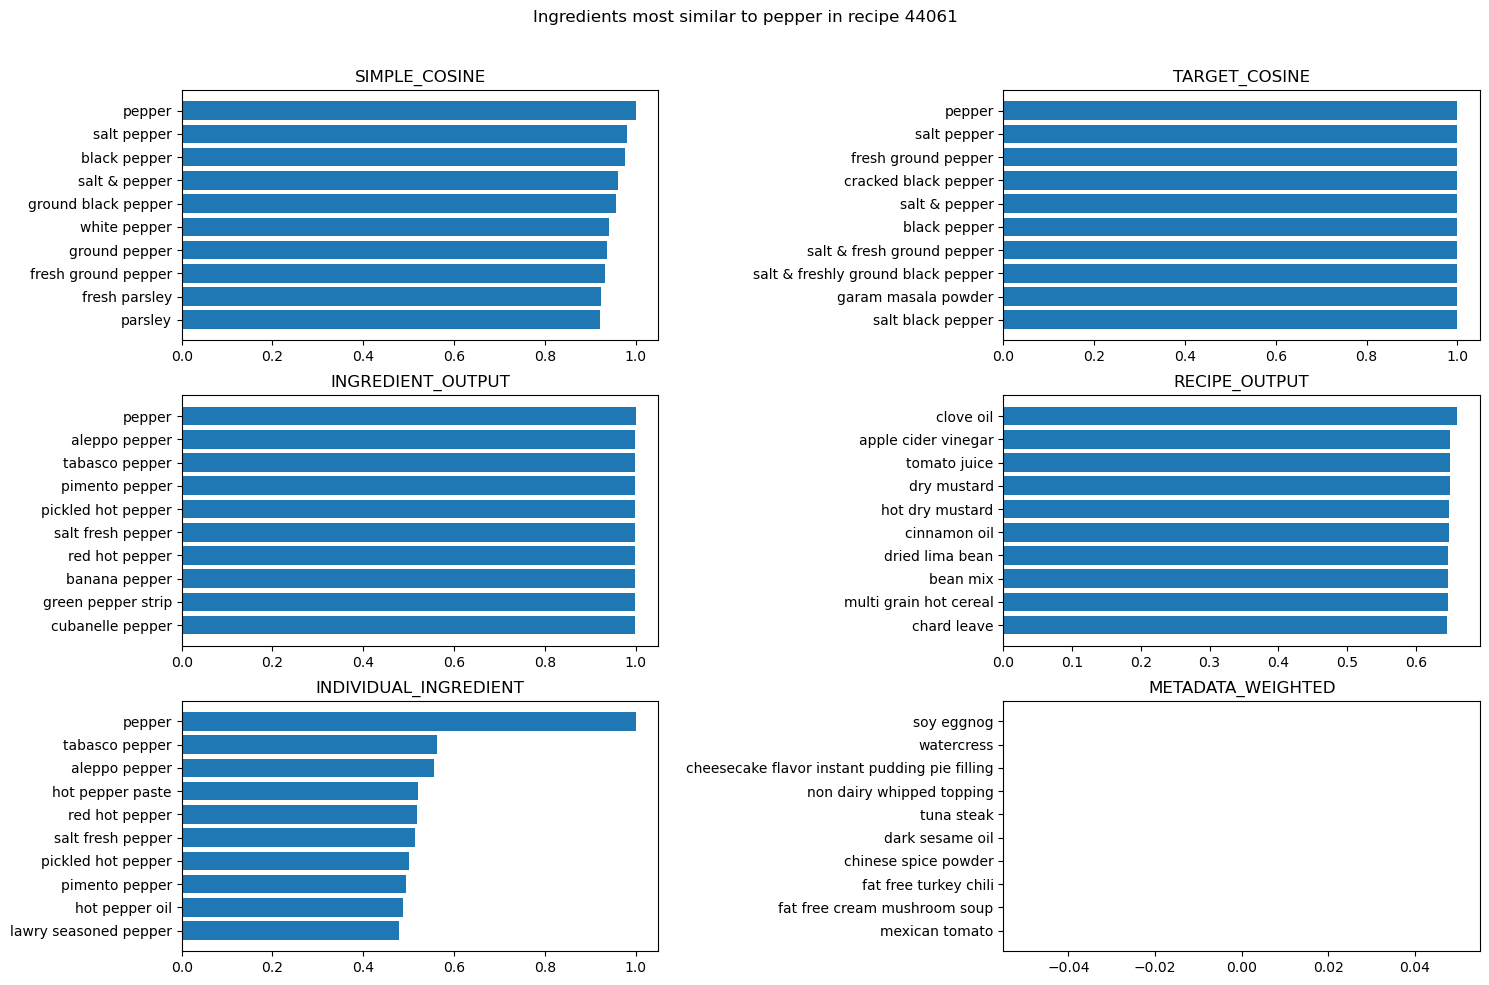

In [150]:
target_recipe = '44061'
target_ing = "pepper"

fig, axs = plt.subplots(3, 2, figsize=(15, 10))

axs_list = [ax for row in axs for ax in row]

for i, metric in enumerate(SimilarityMetric):
    substitutes_evaluation = original_dataset_recommender.evaluate_substitutes(
        target_ing,
        metric,
        target_recipe
    )
    ranked_ingredients = np.argsort(substitutes_evaluation)[::-1]
    top_10_ingredients = [original_dataset_recommender.ingredients[i] for i in ranked_ingredients[:10][::-1]]
    top_10_values = [substitutes_evaluation[i] for i in ranked_ingredients[:10][::-1]]
    axs_list[i].barh(
        top_10_ingredients,
        top_10_values
    )
    axs_list[i].set_title(f"{metric.name}")
plt.tight_layout(w_pad=2)
plt.suptitle(f"Ingredients most similar to {target_ing} in recipe {target_recipe}")

# add top padding
plt.subplots_adjust(top=0.9)


### 8.2. Comparison between embeddings similarity results

In [151]:
adjusted_dataset_recommender = Recommender(
    "data/transformed_actual/",
    "sm_transe_retry",
    "processed/categorized.json",
    "processed/characterized.json",
    metadata_weights=weights,
)

As both original and our adjusted datasets differ in their recipes, the selected recipe and ingredients from recommendation have to be selected from the common subset of recipes.

The metadata are the same for both recommenders, so it will be omitted.

In [153]:
random.seed(42)

adjusted_dataset_recipes = set(adjusted_dataset_recommender.recipe_data.keys())
original_dataset_recipes = set(original_dataset_recommender.recipe_data.keys())

target_recipe = random.choice(tuple(adjusted_dataset_recipes & original_dataset_recipes))
target_ing = random.choice(tuple(original_dataset_recommender.recipe_data[target_recipe].ingredients))

print(f"Target recipe: {target_recipe}")
print(f"Target ingredient: {target_ing}")

Target recipe: 224136
Target ingredient: salt


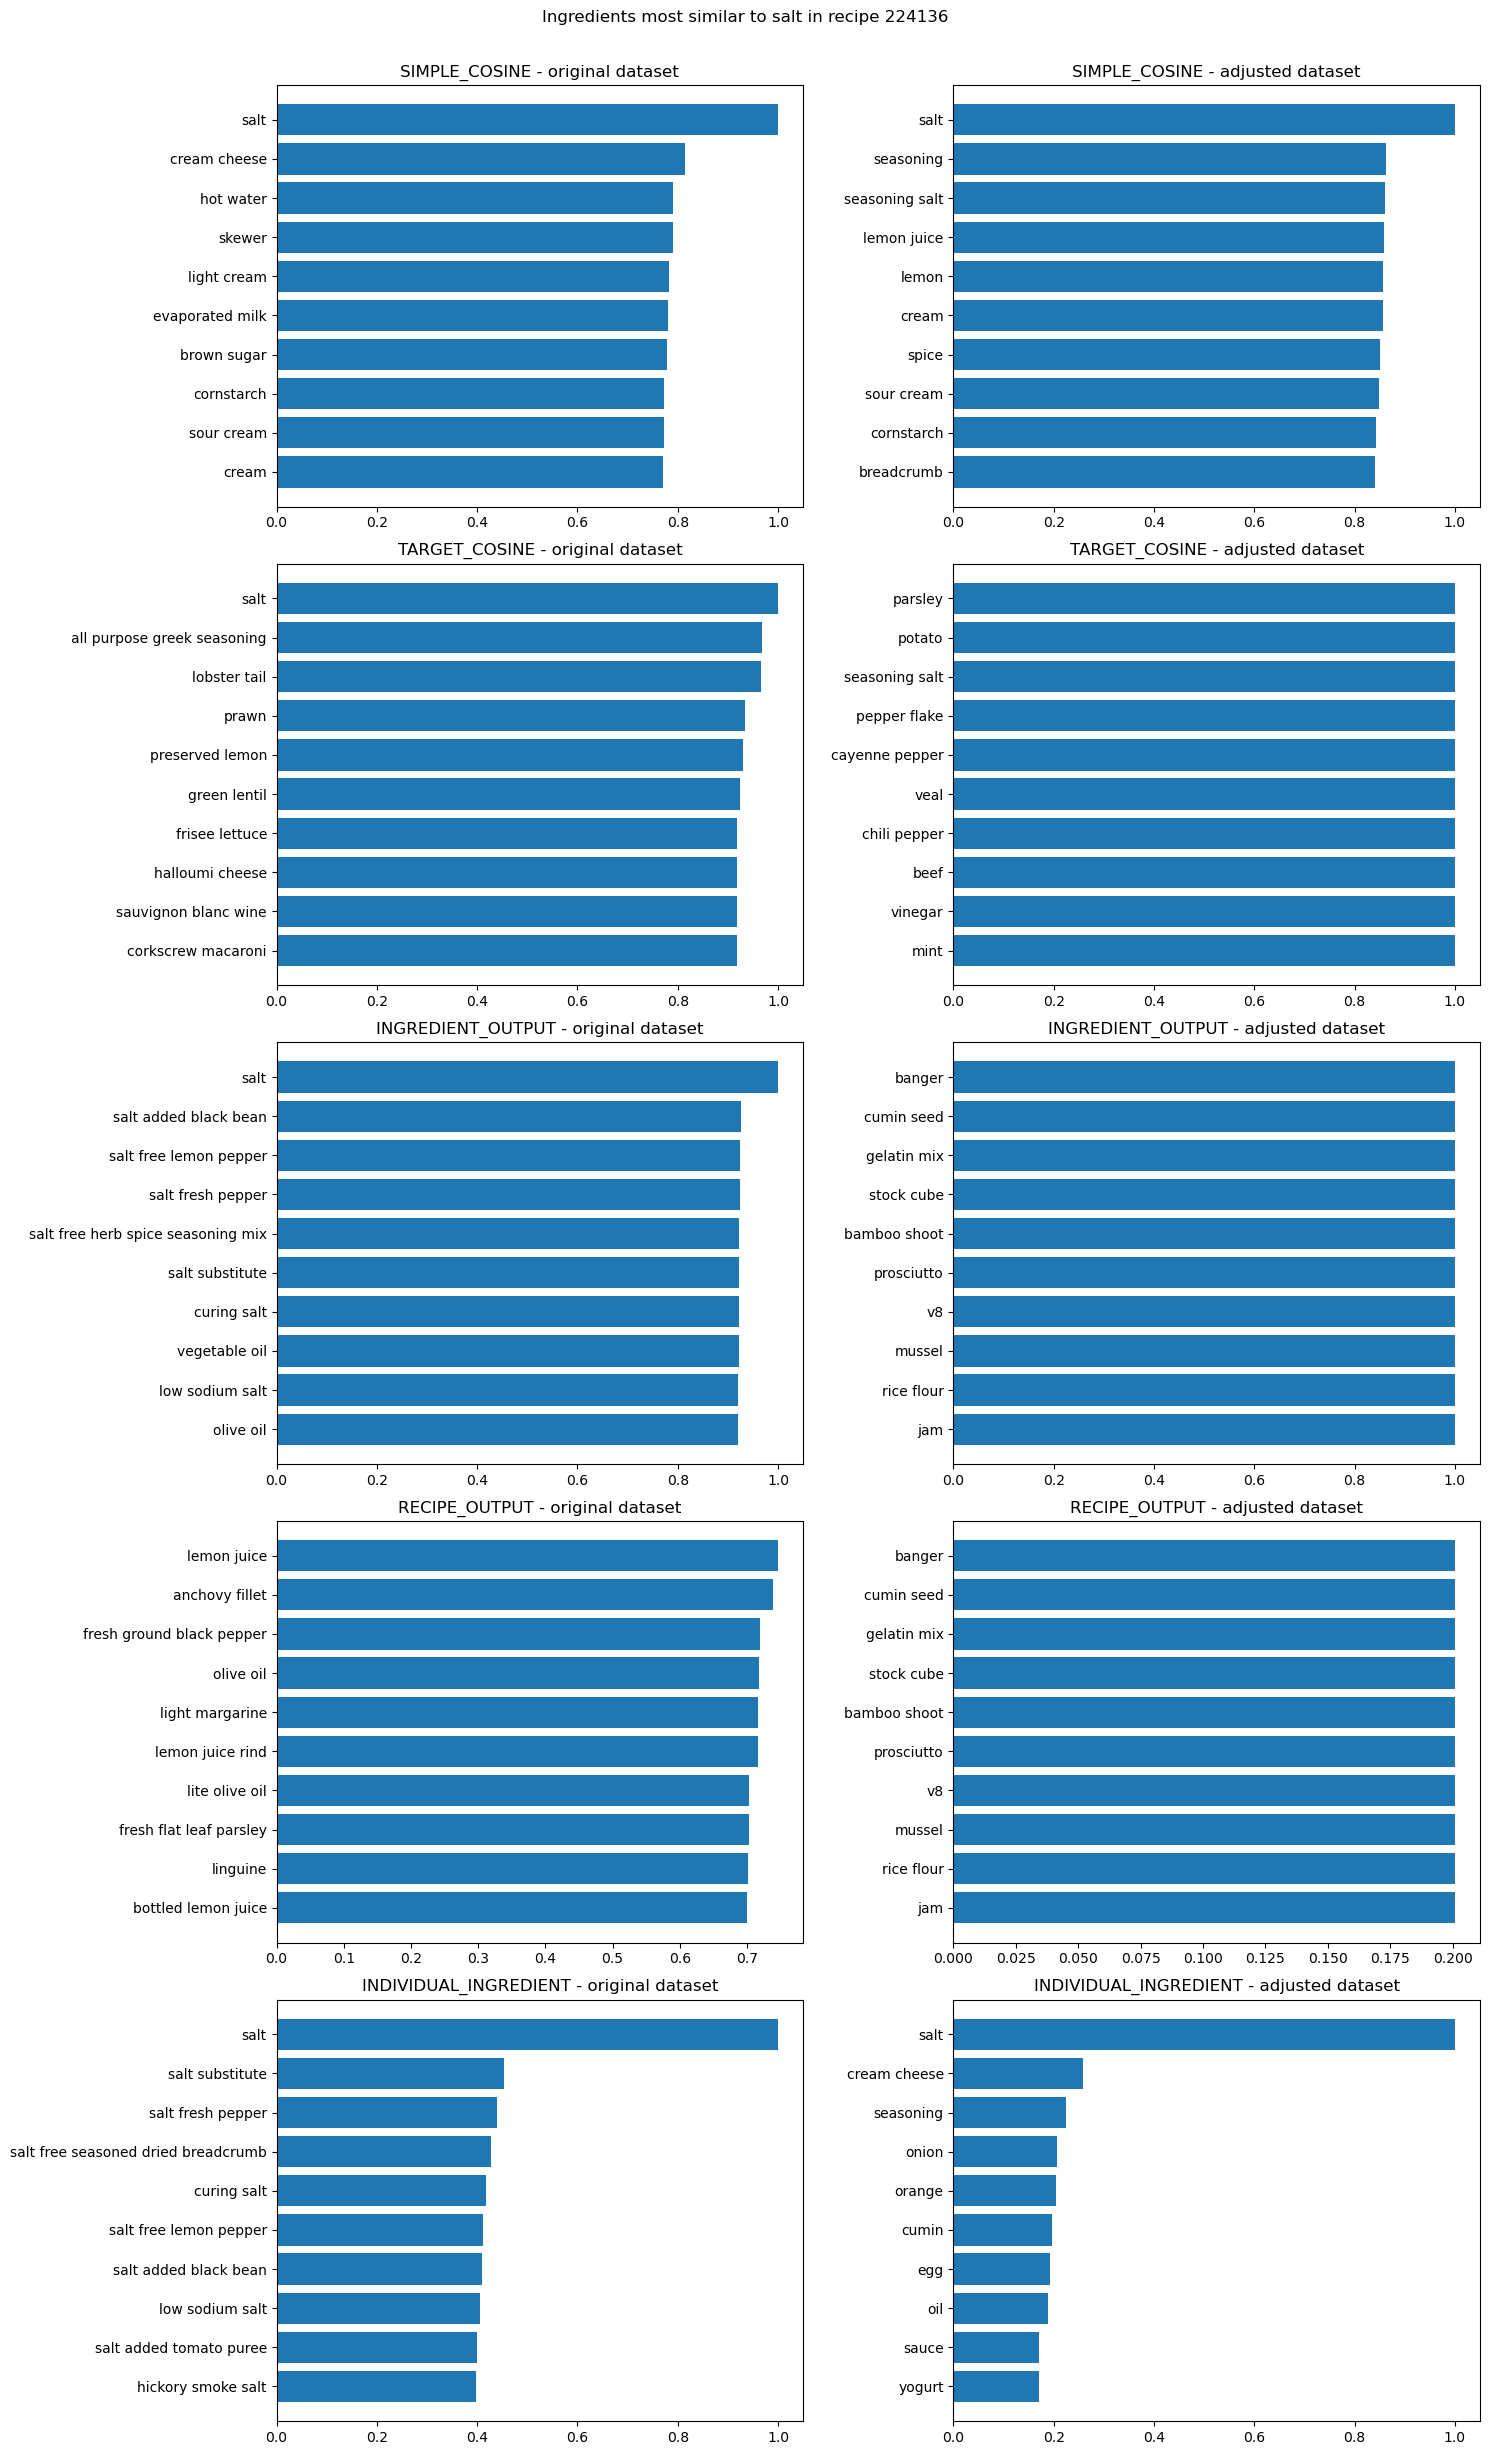

In [154]:
fig, axs = plt.subplots(5, 2, figsize=(15, 25))

metrics = [metric for metric in SimilarityMetric if metric != SimilarityMetric.METADATA_WEIGHTED]
names = ["original dataset", "adjusted dataset"]
for i, recommender in enumerate([original_dataset_recommender, adjusted_dataset_recommender]):
    for j, metric in enumerate(metrics):
        substitutes_evaluation = recommender.evaluate_substitutes(
            target_ing,
            metric,
            target_recipe
        )
        ranked_ingredients = np.argsort(substitutes_evaluation)[::-1]
        top_10_ingredients = [recommender.ingredients[i] for i in ranked_ingredients[:10][::-1]]
        top_10_values = [substitutes_evaluation[i] for i in ranked_ingredients[:10][::-1]]
        axs[j][i].barh(
            top_10_ingredients,
            top_10_values
        )
        axs[j][i].set_title(f"{metric.name} - {names[i]}")

plt.tight_layout(w_pad=2)
plt.subplots_adjust(top=0.95)
plt.suptitle(f"Ingredients most similar to {target_ing} in recipe {target_recipe}")
plt.show()


Given this illustrative example, we see that the our recategorisation achieved the expected prediction results - there are no suggestions for the ingredient being simply variants of the ingredient (butter => butter bud, butter => unsalted butter) or repeating suggestions (low carb pasta, pasta, star shaped pasta, papardelle pasta etc.)

## 9. Final results

To conclude the rankings we need to combine the different metrics into one final ranking. We decided to use the weighted sum of the metrics, with the following weights:

In [155]:
ranking_weights = {
    SimilarityMetric.SIMPLE_COSINE: 0.5,
    SimilarityMetric.TARGET_COSINE: 0.5,
    SimilarityMetric.RECIPE_OUTPUT: 1,
    SimilarityMetric.INGREDIENT_OUTPUT: 1,
    SimilarityMetric.INDIVIDUAL_INGREDIENT: 0.5,
    SimilarityMetric.METADATA_WEIGHTED: 1,
}

These weights were selected based on our own judgement, and can be adjusted by a potential user. These weights influence which aspects of the ingredients are more important in the ranking, and how much the overall recipe should be taken into account.

### 9.1. Examples of final rankings

We hand picked several examples of final rankings to show the results of our approach. We strived to diversify the examples as much as possible.

Its not clear which of the original five metrics did the authors use for their final rankings in the paper (their results differ slightly from all results obtained on the model that was present in the repository which also differs from commented results in _rank_subs_in_recipe.py_ script).

Hence we assume that the authors focused on RECIPE OUTPUT as it uses the embeddings of both operations and the ingredients.

#### 9.1.1. Example 1: replacing chicken in beer chicken recipe

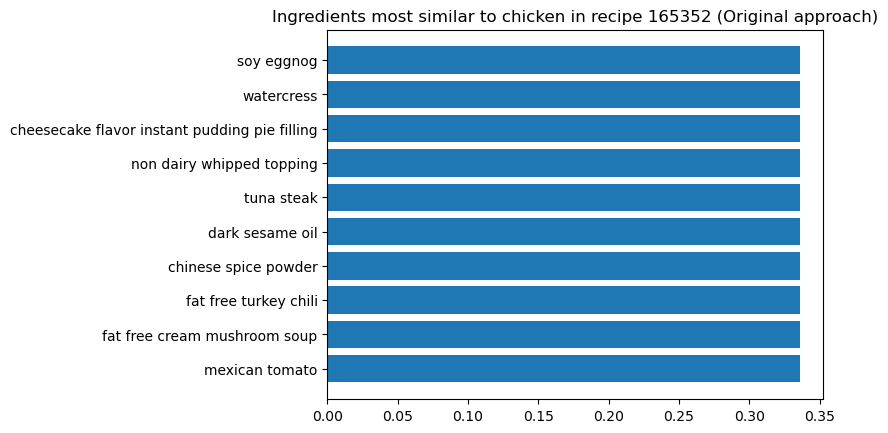

In [201]:
target_ing = "chicken"
target_recipe = "165352"

orig_recommendation = original_dataset_recommender.evaluate_substitutes(
    target_ing,
    SimilarityMetric.RECIPE_OUTPUT,
    target_recipe
)
ranked_original = np.argsort(orig_recommendation)[::-1]
top_10_ingredients = [original_dataset_recommender.ingredients[i] for i in ranked_original[:10][::-1]]
top_10_values = [orig_recommendation[i] for i in ranked_original[:10][::-1]]

plt.barh(
    top_10_ingredients,
    top_10_values
)
plt.title(f"Ingredients most similar to {target_ing} in recipe {target_recipe} (Original approach)")
plt.show()

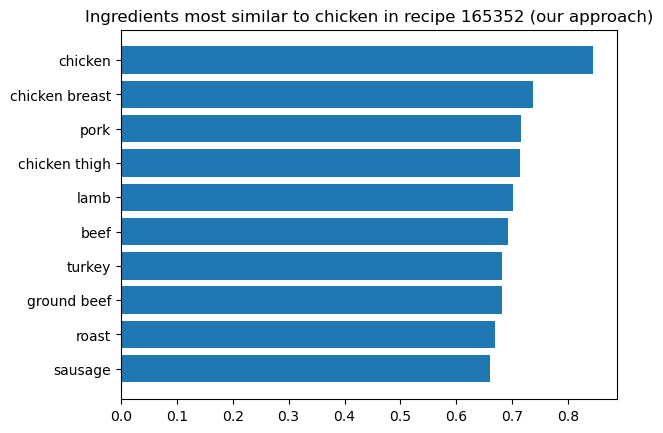

In [202]:
adjusted_recommendations = {
    metric: adjusted_dataset_recommender.evaluate_substitutes(
        target_ing,
        metric,
        target_recipe
    ) * ranking_weights[metric]
    for metric in SimilarityMetric
}

stacked_recommendations = np.vstack(list(adjusted_recommendations.values())).sum(axis=0) / sum(ranking_weights.values())
ranked_stacked = np.argsort(stacked_recommendations)[::-1]
top_10_ingredients = [adjusted_dataset_recommender.ingredients[i] for i in ranked_stacked[:10][::-1]]
top_10_values = [stacked_recommendations[i] for i in ranked_stacked[:10][::-1]]

plt.barh(
    top_10_ingredients,
    top_10_values
)
plt.title(f"Ingredients most similar to {target_ing} in recipe {target_recipe} (our approach)")
plt.show()

While we still got a bit of repetition in the result of our approach (chicken breast and chicken thigh) due to too specific categorisation by AI model, we see that overall the results are much more sensible than the original ones. 

#### 9.1.2. Example 2: replacing red onions in balsamic glazed onions recipe

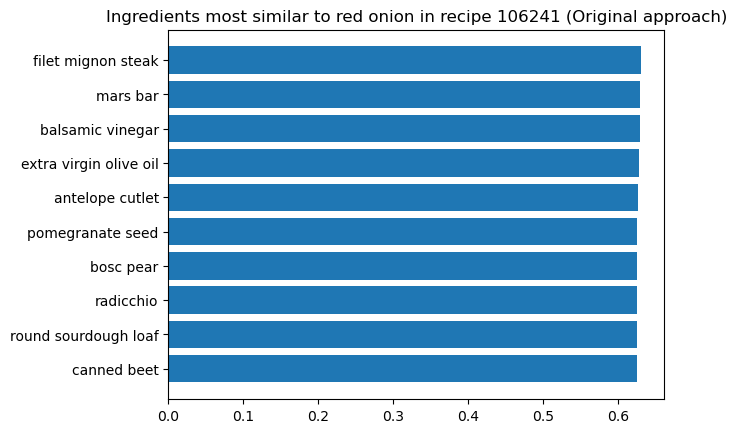

In [214]:
target_ing="red onion"
target_recipe="106241"

orig_recommendation = original_dataset_recommender.evaluate_substitutes(
    target_ing,
    SimilarityMetric.RECIPE_OUTPUT,
    target_recipe
)
ranked_original = np.argsort(orig_recommendation)[::-1]
top_10_ingredients = [original_dataset_recommender.ingredients[i] for i in ranked_original[:10][::-1]]
top_10_values = [orig_recommendation[i] for i in ranked_original[:10][::-1]]

plt.barh(
    top_10_ingredients,
    top_10_values
)
plt.title(f"Ingredients most similar to {target_ing} in recipe {target_recipe} (Original approach)")
plt.show()

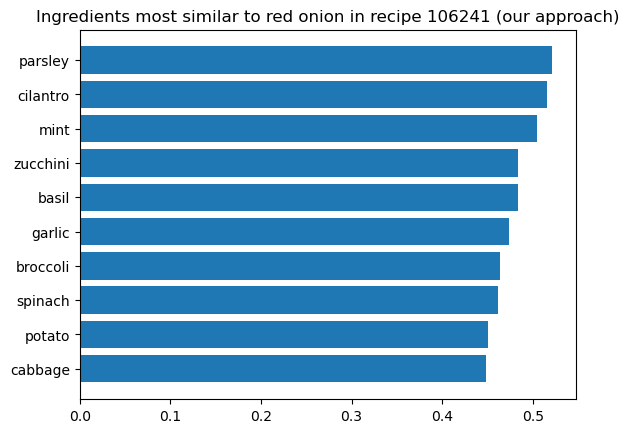

In [204]:
adjusted_recommendations = {
    metric: adjusted_dataset_recommender.evaluate_substitutes(
        final_inversed_map[target_ing],
        metric,
        target_recipe
    ) * ranking_weights[metric]
    for metric in SimilarityMetric
}

stacked_recommendations = np.vstack(list(adjusted_recommendations.values())).sum(axis=0) / sum(ranking_weights.values())

# remove target ingredient from recommendations
stacked_recommendations[adjusted_dataset_recommender.ingredients.index(final_inversed_map[target_ing])] = 0

ranked_stacked = np.argsort(stacked_recommendations)[::-1]
top_10_ingredients = [adjusted_dataset_recommender.ingredients[i] for i in ranked_stacked[:10][::-1]]
top_10_values = [stacked_recommendations[i] for i in ranked_stacked[:10][::-1]]

plt.barh(
    top_10_ingredients,
    top_10_values
)
plt.title(f"Ingredients most similar to {target_ing} in recipe {target_recipe} (our approach)")
plt.show()

Again we seem to obtain much clearer results. Moreover, the decrease in specificity of recommendations gives us more insight into which direction we should go with the replacement.

#### 9.1.3. Example 3: replacing white sugar in banana nut bread recipe

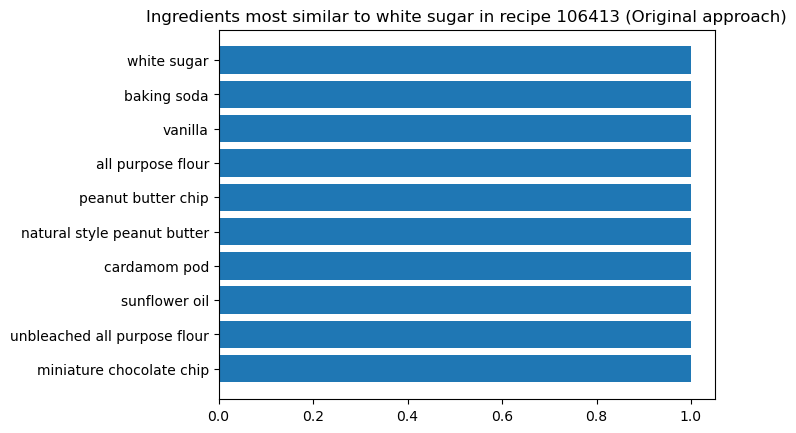

In [205]:
target_ing="white sugar"
target_recipe="106413"

orig_recommendation = original_dataset_recommender.evaluate_substitutes(
    target_ing,
    SimilarityMetric.INGREDIENT_OUTPUT,
    target_recipe
)
ranked_original = np.argsort(orig_recommendation)[::-1]
top_10_ingredients = [original_dataset_recommender.ingredients[i] for i in ranked_original[:10][::-1]]
top_10_values = [orig_recommendation[i] for i in ranked_original[:10][::-1]]

plt.barh(
    top_10_ingredients,
    top_10_values
)
plt.title(f"Ingredients most similar to {target_ing} in recipe {target_recipe} (Original approach)")
plt.show()

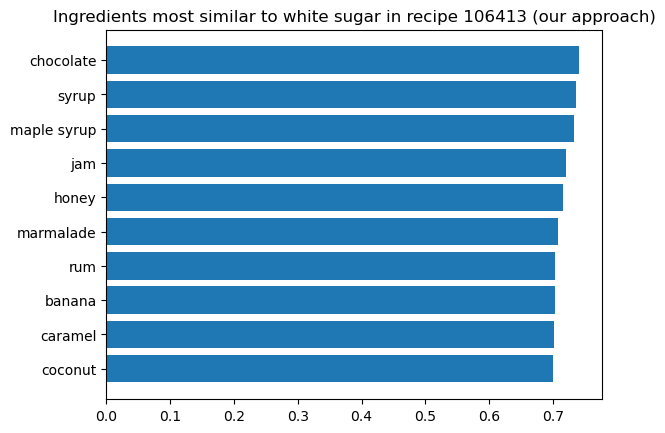

In [206]:
adjusted_recommendations = {
    metric: adjusted_dataset_recommender.evaluate_substitutes(
        final_inversed_map[target_ing],
        metric,
        target_recipe
    ) * ranking_weights[metric]
    for metric in SimilarityMetric
}

stacked_recommendations = np.vstack(list(adjusted_recommendations.values())).sum(axis=0) / sum(ranking_weights.values())

# remove target ingredient from recommendations
stacked_recommendations[adjusted_dataset_recommender.ingredients.index(final_inversed_map[target_ing])] = 0

ranked_stacked = np.argsort(stacked_recommendations)[::-1]
top_10_ingredients = [adjusted_dataset_recommender.ingredients[i] for i in ranked_stacked[:10][::-1]]
top_10_values = [stacked_recommendations[i] for i in ranked_stacked[:10][::-1]]

plt.barh(
    top_10_ingredients,
    top_10_values
)
plt.title(f"Ingredients most similar to {target_ing} in recipe {target_recipe} (our approach)")
plt.show()

Once again we see that the results are much more sensible than the original ones.

#### 9.1.4. Example 4: replacing white sugar in awesome lower fat brownies

To see if the results differ based on the recipe and not only the ingredient, we decided to use a different recipe with the same ingredient.

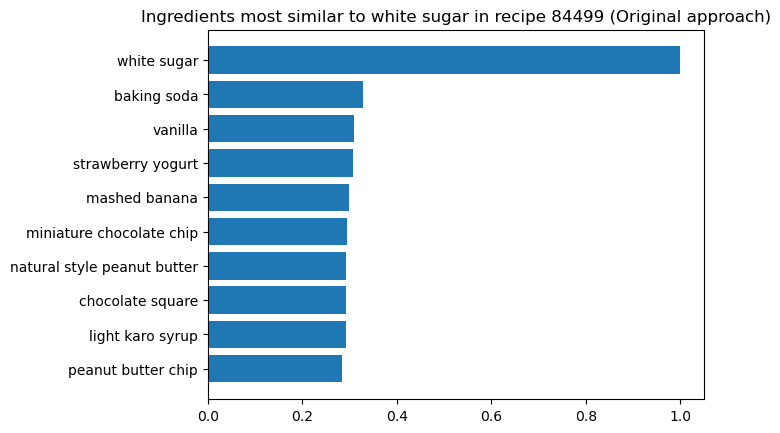

In [207]:
target_ing="white sugar"
target_recipe="84499"

orig_recommendation = original_dataset_recommender.evaluate_substitutes(
    target_ing,
    SimilarityMetric.INDIVIDUAL_INGREDIENT,
    target_recipe
)
ranked_original = np.argsort(orig_recommendation)[::-1]
top_10_ingredients = [original_dataset_recommender.ingredients[i] for i in ranked_original[:10][::-1]]
top_10_values = [orig_recommendation[i] for i in ranked_original[:10][::-1]]

plt.barh(
    top_10_ingredients,
    top_10_values
)
plt.title(f"Ingredients most similar to {target_ing} in recipe {target_recipe} (Original approach)")
plt.show()

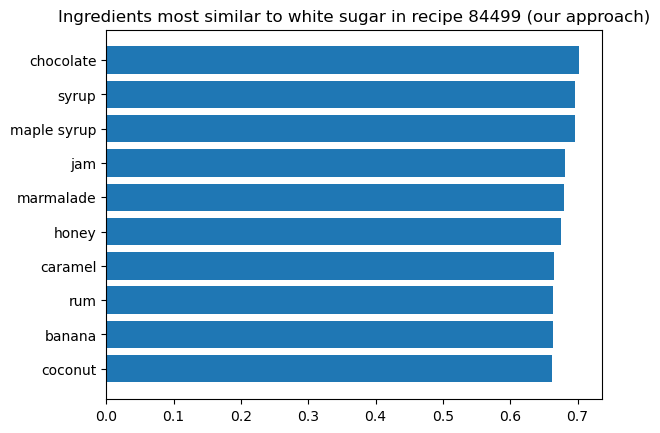

In [208]:
adjusted_recommendations = {
    metric: adjusted_dataset_recommender.evaluate_substitutes(
        final_inversed_map[target_ing],
        metric,
        target_recipe
    ) * ranking_weights[metric]
    for metric in SimilarityMetric
}

stacked_recommendations = np.vstack(list(adjusted_recommendations.values())).sum(axis=0) / sum(ranking_weights.values())

# remove target ingredient from recommendations
stacked_recommendations[adjusted_dataset_recommender.ingredients.index(final_inversed_map[target_ing])] = 0

ranked_stacked = np.argsort(stacked_recommendations)[::-1]
top_10_ingredients = [adjusted_dataset_recommender.ingredients[i] for i in ranked_stacked[:10][::-1]]
top_10_values = [stacked_recommendations[i] for i in ranked_stacked[:10][::-1]]

plt.barh(
    top_10_ingredients,
    top_10_values
)
plt.title(f"Ingredients most similar to {target_ing} in recipe {target_recipe} (our approach)")
plt.show()

The results are similar to the previous example, but the ranking is slightly different, which implies that our approach also takes the recipe into account.

## 10. Conclusions

### 10.1 Summary of our work
1. After reading [EaT-PIM: Substituting Entities in Procedural Instructions using Flow Graphs and Embeddings (Sola S. Shirai, HyeongSik Kim)](https://dspace.rpi.edu/bitstream/handle/20.500.13015/6364/ISWC_EaT_PIM.pdf?sequence=1&isAllowed=y&fbclid=IwAR3RaVCT2_kb0T5NmVNs2ulIxjWkbDBu8T9wfUrIk7pSrjLcRQEeA6BqVkg) it was decided to improve the prediction using two mechanisms:
   - generalising ingredient names from the original dataset (on which the model is trained)
   - creating or finding a dataset that assigns different characteristics to the ingredients such as taste, flavour intesiveness, texture, etc. 

2. The first step in realising the assumptions was to perform Exploratory Data Analysis on the original dataset. This confirmed the potential to perform ingredient grouping. We also carried out an analysis of a found dataset containing a description of the products most frequently purchased in the Netherlands. However, this dataset was not used by both too few ingredients described and too many specifications for the Dutch market (products only available in this country).

3. To group components, we used two approaches:
   - First was to use OpenAI's GPT-3.5 turbo model via the use of an API. Once properly configured, the model grouped the data to create approximately 2,600 groups out of almost 15,000 (including a reduction of the most frequently 8,000 ingredients to create 1,600 categories). It did not assign a group to the 396 ingredients which, after analysis, were found to often have linguistic errors or were finished products (non-ingredients).
   - Second approach was an analytical, linguistic method. It was based on the assumption that large products occur with a description or in plural, so that extracting the nouns (key words) from ingriedients would allow them to be grouped according to the key. The result was the creation of 261 categories, however, while not assigning a group of almost 2,500 food products (these were, however, products rarely found in recipes)

4. In order to prepare the final dataset, we decided to combine the two methods in order to benefit from the advantages of both. By using the analytical method on groups created by AI, we were able to achieve a low number of groups and, at the same time, a low number of uncategorised ingredients.
 
5. The next phase of the project was to prepare a dataset which would assign characteristics to each ingredient. As it was not possible to find a ready-to-use one, we decided to use again the GPT-3.5 turbo model, which described each ingredient in the following categories: origin, type, state, texture, taste, taste-intensity, smell, smell-intensity. 

6. Once we had created the datasets, it remained to prepare the application. However, it turned out that the original approach was not optimal and a lot of work was needed to improve the performance. As a result of the work, we managed to improve the calculations and speed up the operations, but also remove the existing limitation (2048 ingredients). An API was also created for the prepared application to streamline the work and to be able to use the application, for example, in a jupyter notebook. We have also changed the way the metrics used by authors work. We separated the two functions cosine similarity metric and cosine similarity metric considering ingredients in the target recipe. In addition, the next most important metric, which is based on graph embeddings, was now also easy to access via the API. This was important because, with the three metrics mentioned above being independent of each other, it was possible to add another metric to them or modify the existing ones at will. 

7. The metric we added was the similarity between the components based on their characteristics (a dataset created by AI). The features were given weights in such a way that the proposed ingredients changed the taste of the dishes as little as possible while changing e.g. the appearance or smell was less important. The metric used was cosine similarity. In order to evaluate the results obtained, we randomly picked one hundred pairs of ingredients and analysed the similarity value between them. The results turned out to be satisfactory although there were exceptions, however, as this is only one sub-metric it is not necessarily operating at peak efficiency. 

8. The final stage was to train the model but on a dataset we had modified, that is, the ingredients categorised by AI. 

9. In this way, a complete application was created which, based on the composition of the original metrics and those created by us, is able to suggest substitutes for ingredients in dishes. 

### 10.2. Analysis of the obtained results and comparison with the original

The greatest success is the fact that we have managed to set up the model in such a way that the substitute suggestions given are reasonable from the point of view that they are similar and come from the same category or have the same taste.

Examples.
- The original method suggests replacing the chicken with watercress or cheesecake flavour instant pudding pie filling. This suggestion makes absolutely no sense from a culinary point of view. Our model for the same recipe suggests things like chicken breast, pork and other types of meat. It seems a much better suggestion to replace one type of meat with another.
- Another example would be the suggestion to replace white sugar by using baking soda, vanilla or strawberry yogurt. While our model suggests chocolate, syrup or maple syrup. These suggestions are much closer by the fact that they are sweet making the final dish much more likely to be closer to what is in the recipe.

What we have not fully achieved is the complete absence of any proposal to replace the ingredients by itself but under a different name, such as chicken and chicken breast. However, compared to the original model, this happens less frequently and these are single items in the list of suggestions. 


### 10.3. Final conclusion

The final objectives of the project were fully achieved. Suggestions for substitutes are much better and have a logical basis in terms of product category or taste. The modified model more closely resembles a chef whom we can ask what to do when our fridge is empty, rather than a mathematician who, based on statistics, will replace a potato with thyme because they often occur together. At the same time, the project shows how difficult it is to operate with a model in a sphere such as taste or smell. The perception of these senses varies greatly between people, so it is difficult to create a model that is not subjective.